# Mitigating Director Gender Bias in Movie Recommender Systems

By: Michael Garcia-Perez & Christine Deng with mentors Emily Ramond, Parker Addison, Greg Thein from Deloitte

### Table of Contents
To return to the table of contents, click on the number at any major section heading.

[1. Introduction](#1.-Introduction)

[2. Exploratory Data Analysis](#2.-Exploratory-Data-Analysis)

[3. Model Development & Evaluation](#3.-Model-Development-&-Evaluation)

[4. Bias Mitigation](#4.-Bias-Mitigation)

[5. Results Summary](#5.-Results-Summary)

[6. Conclusion & Discussion](#6.-Conclusion-&-Discussion)

### [1.](#Table-of-Contents) Introduction

Past literature across sociology and media studies has widely studied the gender gap in the film industry, namely the underrepresentation of female directors in film production. A comprehensive analysis of over 2000 films released between 1994 and 2016 showed that only 5% of the directors were female (<a href="https://doi.org/10.1177/00222437221100217">Karniouchina et al., 2023</a>). Another study on the gender composition of directors in top-grossing films released between 2007 and 2021 revealed that the ratio of male to female directors was 11:1 (<a href="https://ca-times.brightspotcdn.com/32/1f/434e9de042a9a366c08aac1ed1db/inclusion-in-the-director-2.8.22%20Final.pdf">Smith et al., 2017</a>).

Previous research has found the presence of this gender gap, but the implications of the gender disparity on recommendation systems is not widely researched. Many content distribution platforms, such as Netflix, utilize recommendation models for personalized user content. Our project investigates whether this bias is embedded into the recommendation models.

Additionally, widely adopted bias mitigation tools (such as IBM's AIF360) are optimized for regression and classification tasks. Research into ethical biases within recommender models remains limited, with most studies focusing on statistical biases like popularity bias. Our project fills this gap by investigating whether bias mitigation techniques developed for regression and classification tasks can be extended to recommendation systems. Our aim is to develop a fair movie recommender system that minimizes biases associated with the gender of the director.

### [2.](#Table-of-Contents) Exploratory Data Analysis

### Import Statements

We use Python's import statements so we can utilize external libraries in our project. These libraries contain pre-built functions and classes.

In [1]:
%%capture
!pip install 'aif360[LawSchoolGPA]' > /dev/null
!pip install 'aif360' > /dev/null
!pip install --upgrade tensorflow aif360 > /dev/null
!pip install protobuf==3.19.0 > /dev/null
!pip install 'aif360[AdversarialDebiasing]' > /dev/null
!pip install scikit-surprise > /dev/null
!pip install seaborn > /dev/null

In [2]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Import statements
import random
import gzip
import json
import numpy as np
import math
import pandas as pd
import scipy.optimize
import string
import random
import os
import re
import tarfile
import warnings
import seaborn as sns

from matplotlib import pyplot as plt
from collections import defaultdict
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import svm
from sklearn.metrics import jaccard_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.inspection import permutation_importance
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split as sklearn_train_test_split
     
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import cross_validate, train_test_split
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise import SVD
from surprise import accuracy
     
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.preprocessing import DisparateImpactRemover
     
from scipy.stats import pearsonr
from IPython.display import Markdown, display

pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


### Getting the data

### Reading File Path (Ratings, Users, Movies, Directors, Titles)

The <a href="https://grouplens.org/datasets/movielens/1m/">data</a> for user ratings is sourced from <a href="https://movielens.org/">MovieLens</a>, an online platform that provides personalized movie recommendations based on users' viewing preferences and rating history. Our dataset is composed of 1 million ratings from 6000 different users on 4000 unique movies.

In [3]:
# Update the file paths based on your extraction path
extract_path = ""

# Ratings File
ratings_file = os.path.join(extract_path, "ratings.dat")
ratings_columns = ["UserID", "MovieID", "Rating", "Timestamp"]
ratings_df = pd.read_csv(ratings_file, sep="::", engine="python", header=None, names=ratings_columns, encoding='latin1')

# Movies File
movies_file = os.path.join(extract_path, "movies.dat")
movies_columns = ["MovieID", "Title", "Genres"]
movies_df = pd.read_csv(movies_file, sep="::", engine="python", header=None, names=movies_columns, encoding='latin1')

Each user is uniquely identified by a distinct user ID. Similarly, each movie also has its own unique movie ID.

User ratings fall on a discrete scale ranging from 1 to 5, where a rating of 1 denotes the lowest level of enjoyment with the movie, while a rating of 5 signifies the highest level.

Each row in the dataset corresponds to a single movie rating by a single user. Users can only rate a movie once.

In [4]:
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


Each movie with its unique ID has information on the title, genres, and year.

In [5]:
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


No information about the movie's director is present in the MovieLens dataset.

The <a href="https://figshare.com/articles/dataset/U_S_movies_with_gender-disambiguated_actors_directors_and_producers/4967876">dataset</a> on the gender of the directors comes from Northwestern University's Amaral Lab, which looks at the gender breakdown of the crew of U.S. films released between 1894 and 2011.

In [6]:
# Directors File
directors_file = os.path.join(extract_path, "directors.json")
directors_df = pd.read_json(directors_file)

The relevant columns in this dataset are the gender of the director, as well as the list of movies they have directed. The movies in the list are not identified by title, but rather their unique numerical identifier assigned by IMDb, the world's most popular media database.

In [7]:
directors_df.head()

,first_movie,actress_credits,male_count,_id,gender,name,female_count,last_movie,actor_credits,movies_list
0,1940,False,272,nm0000033,male,Alfred Hitchcock,13,1976,True,"[{'movie_id': 'tt0046912', 'year': 1954, 'type..."
1,1917,False,247,nm0000036,male,Buster Keaton,7,1939,True,"[{'movie_id': 'tt0011541', 'year': 1920, 'type..."
2,1951,False,366,nm0000040,male,Stanley Kubrick,24,1980,True,"[{'movie_id': 'tt0062622', 'year': 1968, 'type..."
3,1968,False,253,nm0000056,male,Paul Newman,15,1987,True,"[{'movie_id': 'tt0093093', 'year': 1987, 'type..."
4,1996,False,59,nm0000114,male,Steve Buscemi,1,2007,True,"[{'movie_id': 'tt0480269', 'year': 2007, 'type..."


As such, we also utilize <a href="https://datasets.imdbws.com/">IMDb's dataset</a> on titles and identifiers. Each row represents a single movie, with relevant columns being its unique identifier, title, and year.

In [8]:
# Titles File
titles_file = os.path.join(extract_path, "title.basics.tsv.gz")
titles_df = pd.read_csv(titles_file, compression='gzip', sep='\t', encoding='utf-8')

In [9]:
titles_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


### Separting Title of Movie from the Year in Movies Dataframe

To clean the dataset, we separate the title of the movie from the year and create a separate column to record the movie's release year.

In [10]:
# Separate title of movie from the year
movies_df['Year'] = movies_df['Title'].apply(lambda x: re.search(r'\((\d{4})\)', x).group(1) if re.search(r'\((\d{4})\)', x) else None)
movies_df['Title'] = movies_df['Title'].apply(lambda x: re.sub(r'\(\d{4}\)', '', x).strip())
movies_df.head()

,MovieID,Title,Genres,Year
0,1,Toy Story,Animation|Children's|Comedy,1995
1,2,Jumanji,Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama,1995
4,5,Father of the Bride Part II,Comedy,1995


IMDb also records information on television serieses, podcasts, video games, and other media forms. Our user ratings from MovieLens only look at movies, so these mediums are irrelevant. We drop the data associated with these mediums.

In [11]:
# Filter to get titles that are only associated with movies
titles_df = titles_df[titles_df['titleType'] == 'movie']
titles_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance
144,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,100,"Documentary,News,Sport"
498,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N
570,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography"
587,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama


### Merge the Movies Dataframe and Titles Dataframe Together Given Movie Title and Year

We join the movie information in the user ratings with the movie information in IMDb's title dataset to link the unique identifier. The identifier is linked to the movie if the title and year match in both datasets, since MovieLens sources its titles from IMDb. Repeated columns (e.g., title, year, genres) are dropped, as well as irrelevant columns (e.g., runtime).

In [12]:
# Merge datasets using Title of movie and year
movie_ids = pd.merge(movies_df, titles_df, left_on=['Title', 'Year'], right_on=['primaryTitle', 'startYear'], how='left')
movie_ids = movie_ids[['MovieID', 'Title', 'Genres', 'Year', 'tconst']]
movie_ids.head()

,MovieID,Title,Genres,Year,tconst
0,1,Toy Story,Animation|Children's|Comedy,1995,tt0114709
1,2,Jumanji,Adventure|Children's|Fantasy,1995,tt0113497
2,3,Grumpier Old Men,Comedy|Romance,1995,tt0113228
3,4,Waiting to Exhale,Comedy|Drama,1995,tt0114885
4,5,Father of the Bride Part II,Comedy,1995,tt0113041


### Get Director Gender for each movie

Because directors can direct multiple movies, each row will be associated with a single director for a single movie. This means that directors who have directed more than one movie will appear in several rows.

Also note that a single movie can have more than one director. So, each movie can also appear in several rows.

In [13]:
# Find gender of each movie identifier associated with the director
genders = directors_df.explode('movies_list')
genders = pd.concat([genders.drop(['movies_list'], axis=1),
                         genders['movies_list'].apply(pd.Series)], axis=1)

### Merging User Rating Movie information and Director Gender data 

Now that both the user ratings data and the director gender data have the IMDb identifier, the datasets can be combined by matching them together.

In [14]:
# Combine datasets based on movie identifier 
merged_df = pd.merge(movie_ids, genders, left_on='tconst', right_on='movie_id', how='left')
merged_df = merged_df.loc[:, ['MovieID', 'Title', 'Genres', 'Year', 'gender', 'name']]
merged_df.head()

,MovieID,Title,Genres,Year,gender,name
0,1,Toy Story,Animation|Children's|Comedy,1995,male,John Lasseter
1,2,Jumanji,Adventure|Children's|Fantasy,1995,male,Joe Johnston
2,3,Grumpier Old Men,Comedy|Romance,1995,male,Howard Deutch
3,4,Waiting to Exhale,Comedy|Drama,1995,male,Forest Whitaker
4,5,Father of the Bride Part II,Comedy,1995,male,Charles Shyer


### Checking for Null Values for Each Dataframe

Before we proceed with any analysis, we examine the distributions and values of the dataset to check for missing values.

In [15]:
# Check for proportion of missing data in movie information
merged_df.isnull().sum() / merged_df.shape[0]

MovieID    0.00000
Title      0.00000
Genres     0.00000
Year       0.00000
gender     0.56348
name       0.56348
dtype: float64

In [16]:
# Check for proportion of missing data in user ratings
ratings_df.isnull().sum()

UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64

No data is missing in the user ratings. To check for placeholder values, we check all values of rating scores. The only values are 1-5, which means there are no placeholder values for missing data.

In [17]:
# Check all values of rating scores
ratings_df['Rating'].value_counts()

Rating
4    348971
3    261197
5    226310
2    107557
1     56174
Name: count, dtype: int64

### Creating Binary Values for Director Gender Columns

To prepare our dataset for model development, we convert the Director's Gender (either 'female' or 'male') to a numerical value. A value of 0 maps to 'female', while a value of 1 maps to 'male'.

In [18]:
# Replace 'male' and 'female' with numerical binary values
merged_df['gender'] = merged_df['gender'].replace({'female': 0, 'male': 1})
merged_df.head()

,MovieID,Title,Genres,Year,gender,name
0,1,Toy Story,Animation|Children's|Comedy,1995,1.0,John Lasseter
1,2,Jumanji,Adventure|Children's|Fantasy,1995,1.0,Joe Johnston
2,3,Grumpier Old Men,Comedy|Romance,1995,1.0,Howard Deutch
3,4,Waiting to Exhale,Comedy|Drama,1995,1.0,Forest Whitaker
4,5,Father of the Bride Part II,Comedy,1995,1.0,Charles Shyer


### Creating New Feature - Director Gender Proportions

Movies can have more than 1 director, so we cannot simply assign each movie to whether it's directed by a male or female. We create a new column that denotes the proportion of directors for each movie that are male, and also find the proportion of directors for each movie that are female.

A movie directed fully by males will have a male_director_proportion of 1.0, and a movie directed fully by females will have a male_director_proportion of 0.0.

In [19]:
# Find proportion of male directors for each movie
male_prop_dict = dict(merged_df.groupby('MovieID')['gender'].sum() / merged_df.groupby('MovieID')['gender'].count())

# Add column with proportion of male directors & proportion of female directors for each row
merged_df['male_director_proportion'] = merged_df['MovieID'].map(male_prop_dict)

merged_df.head()

,MovieID,Title,Genres,Year,gender,name,male_director_proportion
0,1,Toy Story,Animation|Children's|Comedy,1995,1.0,John Lasseter,1.0
1,2,Jumanji,Adventure|Children's|Fantasy,1995,1.0,Joe Johnston,1.0
2,3,Grumpier Old Men,Comedy|Romance,1995,1.0,Howard Deutch,1.0
3,4,Waiting to Exhale,Comedy|Drama,1995,1.0,Forest Whitaker,1.0
4,5,Father of the Bride Part II,Comedy,1995,1.0,Charles Shyer,1.0


To prepare our data for modeling the prediction of ratings, we binarize the variable representing the proportion of male directors involved in each movie. Binarization involves categorizing the variable into two distinct groups based on a specified threshold. To determine this threshold, we examine the distribution of the male_director_proportion across our dataset.

In [20]:
merged_df['male_director_proportion'].value_counts()

male_director_proportion
1.000000    1659
0.000000      81
0.500000      44
0.666667       6
0.750000       4
Name: count, dtype: int64

Binarizing our variables consists of converting our proportions to binary values of either 0 or 1. We considered rounding the proportion, but that would result in only a few data points being 0. There would be a strong imbalance between 0s and 1s due to the overrepresentation of 1s.

So, we decided to convert the value into 1 if the movie is fully directed by males, and 0 if the movie involves at least one female director.

In [21]:
merged_df['all_male_director'] = (merged_df['male_director_proportion'] == 1).astype(float)
merged_df = merged_df.dropna(subset=['gender', 'name', 'male_director_proportion'])
merged_df.head()

,MovieID,Title,Genres,Year,gender,name,male_director_proportion,all_male_director
0,1,Toy Story,Animation|Children's|Comedy,1995,1.0,John Lasseter,1.0,1.0
1,2,Jumanji,Adventure|Children's|Fantasy,1995,1.0,Joe Johnston,1.0,1.0
2,3,Grumpier Old Men,Comedy|Romance,1995,1.0,Howard Deutch,1.0,1.0
3,4,Waiting to Exhale,Comedy|Drama,1995,1.0,Forest Whitaker,1.0,1.0
4,5,Father of the Bride Part II,Comedy,1995,1.0,Charles Shyer,1.0,1.0


In [22]:
merged_df['all_male_director'].value_counts()

all_male_director
1.0    1646
0.0     135
Name: count, dtype: int64

This results in a less imbalanced distribution of 0s and 1s, compared to rounding the proportions.

To reiterate, male_director_proportion demonstrates the ratio of male directors out of the total directors for that movie. all__male_director is a value of 0 or 1, 1 if the movie is entirely male-directed, 0 if not (i.e., female directors are involved).

### Creating New Genre Column

Currently, the columns are stored as a string of multiple genres split by a '|' character. We seperate each unique genre into its own column with a value of 1 if the movie is categorized under that column, and a 0 if not. A movie can have more than one genre, so multiple values of 1 across columns can be present for a single row.

Converting the genres into a binary value of 0 and 1 is necessary to prepare our dataset for model development.

In [23]:
# Split the genres column into a list of genres
merged_df['Genres'] = merged_df['Genres'].str.split('|')

# Create a list of unique genres
unique_genres = set(genre for genres_list in merged_df['Genres'] for genre in genres_list)

# Initialize binary columns for each genre with zeros
for genre in unique_genres:
    merged_df[genre] = 0

# Update binary columns using vectorized operations
for genre in unique_genres:
    merged_df[genre] = merged_df['Genres'].apply(lambda x: 1 if genre in x else 0)

# Drop the original genres column
merged_df = merged_df.drop('Genres', axis=1)

In [24]:
merged_df.head()

,MovieID,Title,Year,gender,name,male_director_proportion,all_male_director,Crime,Comedy,Fantasy,...,Romance,Drama,Adventure,Documentary,Thriller,Children's,Action,Western,Animation,War
0,1,Toy Story,1995,1.0,John Lasseter,1.0,1.0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
1,2,Jumanji,1995,1.0,Joe Johnston,1.0,1.0,0,0,1,...,0,0,1,0,0,1,0,0,0,0
2,3,Grumpier Old Men,1995,1.0,Howard Deutch,1.0,1.0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale,1995,1.0,Forest Whitaker,1.0,1.0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II,1995,1.0,Charles Shyer,1.0,1.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Merging Movies Dataframe with Ratings Dataframe on MovieID to Include Rating and UserID Columns

Now that we have the movie information for the user ratings complete, we combine the unique Movie ID assigned by MovieLens with the full movie information (with director gender) from the merged dataset above.

Each row represents 1 movie rated by 1 user.

For clarity purposes, we rename columns to specify that the gender in the data represents the director's gender, and the rating represents the user's rating. We also drop irrelevant columns, such as the director's name.

In [25]:
# Merge Movies with Ratings on MovieID
Ratings_and_Movies = pd.merge(merged_df, ratings_df[['MovieID', 'Rating', 'UserID']], on='MovieID').drop('name', axis=1)

# Rename columns for clarity
Ratings_and_Movies.rename(columns={'Rating': 'User_Rating', 'gender': 'Director_Gender'}, inplace=True)

Ratings_and_Movies.head()

,MovieID,Title,Year,Director_Gender,male_director_proportion,all_male_director,Crime,Comedy,Fantasy,Horror,...,Adventure,Documentary,Thriller,Children's,Action,Western,Animation,War,User_Rating,UserID
0,1,Toy Story,1995,1.0,1.0,1.0,0,1,0,0,...,0,0,0,1,0,0,1,0,5,1
1,1,Toy Story,1995,1.0,1.0,1.0,0,1,0,0,...,0,0,0,1,0,0,1,0,4,6
2,1,Toy Story,1995,1.0,1.0,1.0,0,1,0,0,...,0,0,0,1,0,0,1,0,4,8
3,1,Toy Story,1995,1.0,1.0,1.0,0,1,0,0,...,0,0,0,1,0,0,1,0,5,9
4,1,Toy Story,1995,1.0,1.0,1.0,0,1,0,0,...,0,0,0,1,0,0,1,0,5,10


We also rename the columns to lowercase and use underscores for clarity purposes and to keep the column name style consistent.

In [26]:
# Rename columns to lowercase
column_mapping = {
    'Title': 'title',
    'MovieID': 'movie_id',
    'Year': 'year',
    'User_Rating': 'user_rating',
    'UserID': 'user_id',
    'User_Gender': 'user_gender',
    'Drama': 'drama',
    'Romance': 'romance',
    'Thriller': 'thriller',
    'Action': 'action',
    'Sci-Fi': 'sci_fi',
    'Adventure': 'adventure',
    'Mystery': 'mystery',
    'Comedy': 'comedy',
    "Children's": 'childrens',
    'Animation': 'animation',
    'War': 'war',
    'Western': 'western',
    'Documentary': 'documentary',
    'Film-Noir': 'film_noir',
    'Horror': 'horror',
    'Fantasy': 'fantasy',
    'Crime': 'crime',
    'Musical': 'musical',
    'Director_Gender': 'director_gender',
    'male_director_proportion': 'male_director_proportion',
    'all_male_director': 'all_male_director'
}

Ratings_and_Movies.rename(columns=column_mapping, inplace=True)
Ratings_and_Movies = Ratings_and_Movies.dropna(subset=['all_male_director', 'director_gender'])

We drop duplicate rows where the combination of MovieID and UserID is identical, ensuring that each unique user-movie pair has only one corresponding rating.

We also remove the column with the director's gender because we will analyze the proportion of male directors associated with each movie, so the individual director gender is not necessary to retain.

In [27]:
Ratings_and_Movies.drop_duplicates(subset=['movie_id', 'user_id'], inplace=True)
Ratings_and_Movies = Ratings_and_Movies.drop('director_gender', axis=1)
Ratings_and_Movies.head()

,movie_id,title,year,male_director_proportion,all_male_director,crime,comedy,fantasy,horror,mystery,...,adventure,documentary,thriller,childrens,action,western,animation,war,user_rating,user_id
0,1,Toy Story,1995,1.0,1.0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,5,1
1,1,Toy Story,1995,1.0,1.0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,4,6
2,1,Toy Story,1995,1.0,1.0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,4,8
3,1,Toy Story,1995,1.0,1.0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,5,9
4,1,Toy Story,1995,1.0,1.0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,5,10


### Ratings and Director Gender EDA

Our recommender system looks at how users compare across movie ratings, using similarity between users to determine which movies to recommend. By visualizing the distribution of rating scores, we are able to see users' tendencies when rating movies. Most ratings are on the higher side with a score of 4. There are less low ratings of 1 & 2 in our dataset.

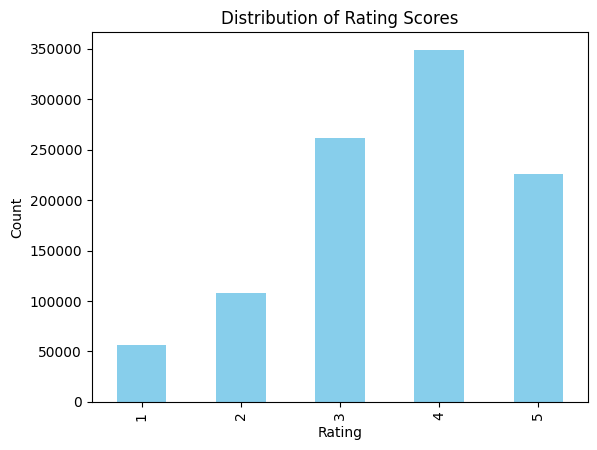

In [64]:
%matplotlib inline

# Count the occurrences of each rating
rating_counts = ratings_df['Rating'].value_counts()

# Sort the ratings in ascending order
rating_counts = rating_counts.sort_index()

# Create a bar plot
rating_counts.plot(kind='bar', color='skyblue')

# Add title and labels
plt.title('Distribution of Rating Scores')
plt.xlabel('Rating')
plt.ylabel('Count')

plt.show()

We further separate this by the director's gender breakdown to compare the proportion of ratings between male versus female directors. Movies with all male directors received a greater proportion of 5 star ratings. This leads us to define the rating of 5 stars as a high rating, using this to identify bias in the next section to determine whether fully male-directed movies are advantaged by our model to receive a prediction of 5 stars.

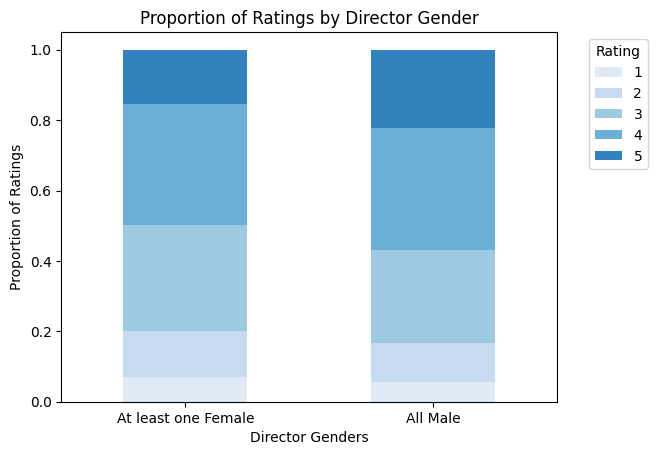

In [65]:
# Group by 'director_gender' and 'user_rating', and count occurrences
rating_counts_by_gender = Ratings_and_Movies.groupby(['all_male_director', 'user_rating']).size().unstack()

# Normalize by the total number of ratings for each gender
rating_percentage_by_gender = rating_counts_by_gender.div(rating_counts_by_gender.sum(axis=1), axis=0)

# Define custom color palette with ordinal colors
colors = ['#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#3182bd']  # Light to dark shades for 1-star to 5-star

# Plotting
ax = rating_percentage_by_gender.plot(kind='bar', stacked=True, color=colors)

# Set custom x-axis labels
ax.set_xticklabels(['At least one Female', 'All Male'], rotation=0)

# Set custom legend outside the plot
plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Proportion of Ratings by Director Gender')
plt.xlabel('Director Genders')
plt.ylabel('Proportion of Ratings')

plt.show()

Next, we check for gender imbalance in our dataset. Given societal context, we expect most movies to be directed by males. This is reflected in our dataset with a severe imbalance between the proportion of movies directed by males versus females.

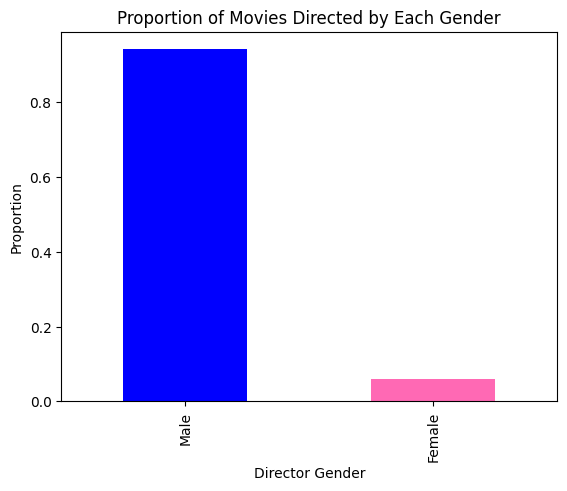

In [66]:
# Proportion of movies in dataset directed by each gender
gender_labels = merged_df['gender'].map({1: 'Male', 0: 'Female'})
props = gender_labels.value_counts() / gender_labels.value_counts().sum()

# Define colors for male and female directors
colors = ['blue', '#FF69B4']

plot = props.plot(kind='bar', color=colors)  # Set colors for male and female directors
plt.xlabel('Director Gender')
plt.ylabel('Proportion')
plt.title('Proportion of Movies Directed by Each Gender')

plt.show()

While it is important to acknowledge the strong class imbalance within the dataset, training a linear regression model to predict movie ratings did not reveal a substantial discrepancy in accuracy between male-directed and female-directed movies. 

The model demonstrated comparable performance in predicting ratings for both director genders. The mean squared error (MSE) for predicting ratings of female-directed movies was only slightly lower than that for male-directed movies. There is not a significant difference in MSE between the different director genders.

Because of this similar performance in MSE across director genders, plus the time-constraints of the project and limited resources, we decide not to correct the class imbalance. This imbalance does not significantly impact the predictive capabilities of the linear regression model.

In [31]:
# Suppress FutureWarnings related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils.validation")

# Select common features
common_features = ['year', 'documentary', 'romance', 'fantasy', 'western', 'thriller',
            'childrens', 'film_noir', 'drama', 'comedy', 'adventure', 'horror', 'crime', 'action', 'mystery', 'war', 'musical', 'animation', 'sci_fi', 'male_director_proportion', 'all_male_director']

# Filter data for fully male directed movies separately
df_male_director = Ratings_and_Movies[Ratings_and_Movies['all_male_director'] == 1]
df_female_director = Ratings_and_Movies[Ratings_and_Movies['all_male_director'] == 0]

# Function to train and evaluate a model
def train_and_evaluate(data, director_gender):
    X = data[common_features]
    y = data['user_rating']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = sklearn_train_test_split(X, y, test_size=0.2, random_state=42)

    # Create a linear regression model
    model = LinearRegression()

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error for {director_gender}: {mse}')

# Train and evaluate models for male directed movies vs female directed movies
train_and_evaluate(df_male_director, 'Movies with all Male Directors')
train_and_evaluate(df_female_director, 'Movies with Female Directors')

Mean Squared Error for Movies with all Male Directors: 1.1619440978928832
Mean Squared Error for Movies with Female Directors: 1.1397977798088128


Our model utilizes features such as the genre of the movie and year to determine whether a user is likely to give that movie a high rating, based on their previous ratings for movies of similar features. So, we examine the distribution of how movie genres and years compare across the different director genders.

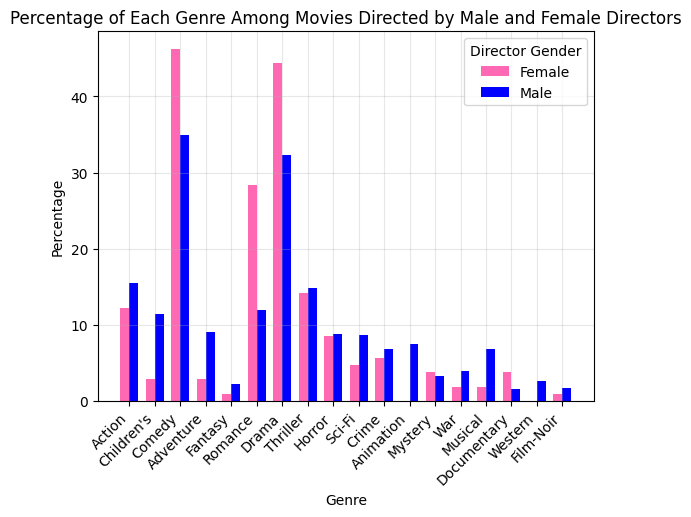

In [32]:
# Group by 'director_gender' and calculate sum of genre columns
genre_counts_by_gender = merged_df.groupby('gender')[['Action', "Children's", 'Comedy', 'Adventure', 'Fantasy', 'Romance', 'Drama', 'Thriller', 'Horror', 'Sci-Fi', 'Crime', 'Animation', 'Mystery', 'War', 'Musical', 'Documentary', 'Western', 'Film-Noir']].sum()

# Calculate total movies by gender
total_movies_by_gender = merged_df['gender'].value_counts()

# Calculate percentages
genre_percentage_by_gender = genre_counts_by_gender.div(total_movies_by_gender, axis=0) * 100

# Plotting
bar_width = 0.35
index = np.arange(len(genre_percentage_by_gender.columns))

female_data = genre_percentage_by_gender.loc[0.0]
male_data = genre_percentage_by_gender.loc[1.0]

plt.bar(index, female_data, bar_width, label='Female', color='#FF69B4')
plt.bar(index + bar_width, male_data, bar_width, label='Male', color='blue')

# Set custom x-axis labels
plt.xlabel('Genre')
plt.ylabel('Percentage')
plt.title('Percentage of Each Genre Among Movies Directed by Male and Female Directors')
plt.xticks(index + bar_width / 2, genre_percentage_by_gender.columns, rotation=45, ha='right')

# Set custom legend
plt.legend(title='Director Gender')

# Customize grid lines
plt.grid(alpha=0.3)

plt.show()

Certain genres, such as animation and western, are dominated by male directors. Users who predominantly rate movies within these genres are likely to receive higher predicted ratings for male-directed movies due to the disproportionate representation of male directors.

While the MSE is comparable across the different director genders, we now look into fairness. We know that the model does not perform significantly better for male directors versus female directors, but as seen in the rating breakdown by director gender, we are inclined to believe movies with all male directors receive higher predictions for a perfect rating of 5.

## Checking for Bias

#### Remove non-numerical column (title) to make dataset compatible with AIF360

We remove the title of the movie because it is not relevant to our model.

In [33]:
Ratings_and_Movies = Ratings_and_Movies.drop('title', axis=1)

In our model, we designate a perfect rating of 5 as the favorable outcome, for the reasons mentioned above. Given the societal context of gender disparities, we acknowledge movies fully directed by males as the privileged group within our analysis.

In [34]:
# Define the protected attributes
protected_attributes = ['all_male_director']

# Define the favorable and unfavorable labels
favorable_classes = [5]  # 5 is a high rating (favorable)

# Create a StandardDataset
dataset = StandardDataset(Ratings_and_Movies, label_name='user_rating', favorable_classes=favorable_classes,
                          protected_attribute_names=protected_attributes,
                          privileged_classes=[[1]])  # Only one class for all_male_director (e.g., male is privileged)

# Calculate the disparate impact before any mitigation
metric_before = BinaryLabelDatasetMetric(dataset, unprivileged_groups=[{'all_male_director': 0}],
                                         privileged_groups=[{'all_male_director': 1}])
disparate_impact_before = metric_before.disparate_impact()

print("Disparate Impact Before Mitigation:", disparate_impact_before)
print("Statistical Parity Difference Before Mitigation:", metric_before.statistical_parity_difference())

Disparate Impact Before Mitigation: 0.6936728137652075
Statistical Parity Difference Before Mitigation: -0.06811093669303028


#### Disparate Impact:
- A Disparate Impact value of 0.6936728137652075 (before mitigation) shows an imbalance in the favorable outcome (perfect rating of 5) between male and female directors within the dataset. Fully male-directed movies, as the privileged group, are more likely to achieve the favorable outcome compared to movies with female directors.
- The 3/4ths rule (the fraction 3/4 maps to a percentage of 75%) is a standard threshold used for disparate impact analysis. According to this rule, if the favorable outcome rate for a group is less than 75%, bias is present in the dataset.
- Our Disparate Impact value of 0.6936728137652075 maps to a percentage of ~69%, which is less than 75%. Movies with female directors are getting 5-star ratings about 69% as often as fully male-directed movies. Since this is less than 75%, there is a bias in how 5-star ratings are distributed between the different gender breakdowns of the movie directors.

#### Statistical Parity:
- A Statistical Parity Difference value of -0.06811093669303028 (before mitigation) indicates a difference in the proportion of favorable outcomes (perfect ratings of 5) between fully-male directed movies and movies with female directors. The negative value suggests that movies with female directors experience a lower rate of favorable outcomes compared to fully-male directed movies. It implies that fully male-directed movies receive a higher proportion of 5-star ratings than female-directed movies.
- A Statistical Parity Difference close of 0 shows no difference in the proportion of favorable outcomes between different groups. Our value is close to 0 and does not show a discernible bias.

### [3.](#Table-of-Contents) Model Development & Evaluation

#### Random Forest (Classification Algorithm)
- The goal is to use a Random Forest Classifier to predict whether a user will give a movie a perfect rating (5 stars) based on various movie attributes, including the year of release, genre, and whether or not the movies is fully male-directed. The model is trained and evaluated on this binary classification task, and additional focus is placed on assessing potential biases related to the protected attribute 'all_male_director' to ensure fair and unbiased predictions. The code performs hyperparameter tuning, calculates fairness metrics, and reports on both the model's predictive accuracy and fairness considerations.

In [35]:
# Features and target variable
X = Ratings_and_Movies[['year', 'documentary', 'romance', 'fantasy', 'western', 'thriller',
                         'childrens', 'film_noir', 'drama', 'comedy', 'adventure', 'horror', 'crime', 
                         'action', 'mystery', 'war', 'musical', 'animation', 'sci_fi', 'male_director_proportion', 'all_male_director']]
y = (Ratings_and_Movies['user_rating'] == 5).astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = sklearn_train_test_split(X, y, test_size=0.2, random_state=42)

# Define the protected attributes
protected_attributes = ['all_male_director']

# Define the privileged and unprivileged groups
privileged_groups = [{'all_male_director': 1}]
unprivileged_groups = [{'all_male_director': 0}]

# Initialize the Random Forest Classifier model
rf_classifier = RandomForestClassifier(random_state=42)

# Define the parameter grid for n_estimators
param_grid = {'n_estimators': [5, 100, 150, 200]}

# Perform grid search using GridSearchCV
grid_search = GridSearchCV(rf_classifier, param_grid, cv=4, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_rf_model = grid_search.best_estimator_

# Make predictions on the test data using the best model
y_pred_rf = best_rf_model.predict(X_test)

# Combine X_test, y_test, and y_pred_rf into a new DataFrame
test_results = pd.concat([X_test, pd.DataFrame({'user_rating': y_test, 'predicted_rating': y_pred_rf})], axis=1)

# Extract the protected attribute 'director_gender' from the original dataset
test_results['all_male_director'] = Ratings_and_Movies.loc[X_test.index, 'all_male_director']

# Create a StandardDataset
dataset = StandardDataset(df=test_results,
                          label_name='user_rating', favorable_classes=[1], # This is 1 instead of 5 given that user_ratring is transformed to binary values
                          protected_attribute_names=protected_attributes,
                          privileged_classes=[[1]])  # Only one class for all_male_director (e.g., male is privileged)

# Create a BinaryLabelDatasetMetric for bias metrics
dataset_metric = BinaryLabelDatasetMetric(dataset, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

# Display bias metrics
display(Markdown("#### Bias Metrics"))
print("Disparate Impact:", dataset_metric.disparate_impact())
print("Statistical Parity Difference:", dataset_metric.statistical_parity_difference())

# Calculate accuracy using scikit-learn's accuracy_score
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# Display Random Forest Classifier Metrics
display(Markdown("#### Random Forest Classifier Metrics"))
print("Best n_estimators:", best_rf_model.n_estimators)
print("Accuracy:", accuracy_rf)
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

#### Bias Metrics

Disparate Impact: 0.6683266010922667
Statistical Parity Difference: -0.07358900435300986


#### Random Forest Classifier Metrics

Best n_estimators: 150
Accuracy: 0.7880449340387062

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.97      0.88     93464
           1       0.56      0.12      0.19     26000

    accuracy                           0.79    119464
   macro avg       0.68      0.55      0.54    119464
weighted avg       0.75      0.79      0.73    119464



1. Classification Report
- Precision: Precision is the ratio of correctly predicted positive observations to the total predicted positives. It is a measure of how many of the predicted positive instances are actually positive.
- Recall (Sensitivity or True Positive Rate): Recall is the ratio of correctly predicted positive observations to the all observations in the actual class. It is a measure of how many actual positive instances were captured by the model.
- F1-score: The F1-score is the weighted average of precision and recall. It is a metric that balances precision and recall. It ranges from 0 to 1, with higher values indicating a better balance.
- Support: The number of actual occurrences of the class in the specified dataset.

2. Class 0 (user_rating is not 5):
- Interpretation: Precision for class 0 (user rating not equal to 5) is 0.80, indicating that among the instances predicted as not having a user rating of 5, 80% were correct. Recall for class 0 is 0.97, indicating that the model identified 97% of instances with a user rating not equal to 5. F1-score for class 0 is 0.88, providing a balance between precision and recall.

3. Class 1 (user_rating is 5):
- Interpretation: Precision for class 1 (user rating equal to 5) is 0.56, indicating that among the instances predicted as having a user rating of 5, 56% were correct. Recall for class 1 is 0.12, indicating that the model identified only 12% of instances with a user rating equal to 5. F1-score for class 1 is 0.19, indicating a trade-off between precision and recall for instances with a user rating equal to 5.

4. Overall Metrics (macro avg, weighted avg):
- Macro avg: The unweighted average of precision, recall, and F1-score across all classes. It treats all classes equally.
- Weighted avg: The weighted average of precision, recall, and F1-score, where each class's contribution is weighted by the number of true instances. It provides a better representation when class sizes are imbalanced.

5. Bias Metrics
- Disparate Impact: Measures the ratio of favorable outcomes for the unprivileged group to the privileged group. A Disparate Impact of ~0.67 suggests that the unprivileged group is at a disadvantage compared to the privileged group, as they are less likely to receive favorable outcomes.
- Statistical Parity Difference: Measures the difference in the proportion of favorable outcomes between the unprivileged and privileged groups. A Statistical Parity Difference of -0.074 suggests a slight disadvantage for the unprivileged group, as the proportion of favorable outcomes is slightly lower compared to the privileged group.

7. Summary:
- In summary, while the model achieves high accuracy, the lower recall for class 1 suggests that it might have difficulty correctly identifying instances with a user rating equal to 5. In terms of bias, the disparate impact suggests that the underpriviledged group is at a disadvantage compared to the priviledged group, as they are less likely to recieve favorable outcomes, or in this case, 5 star ratings.

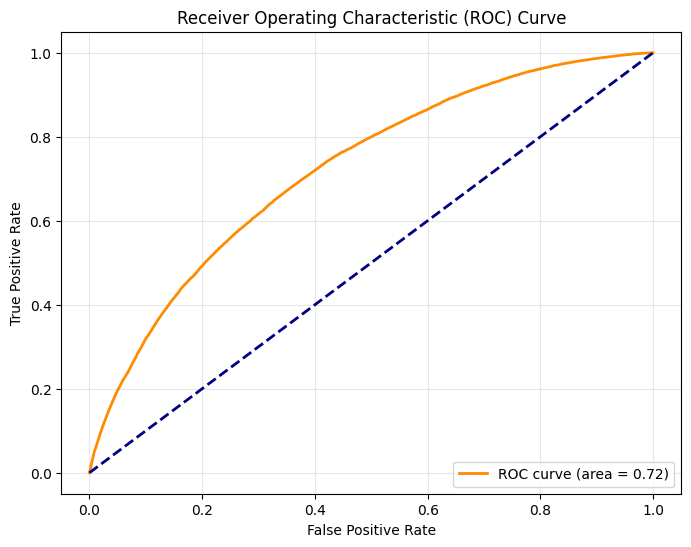

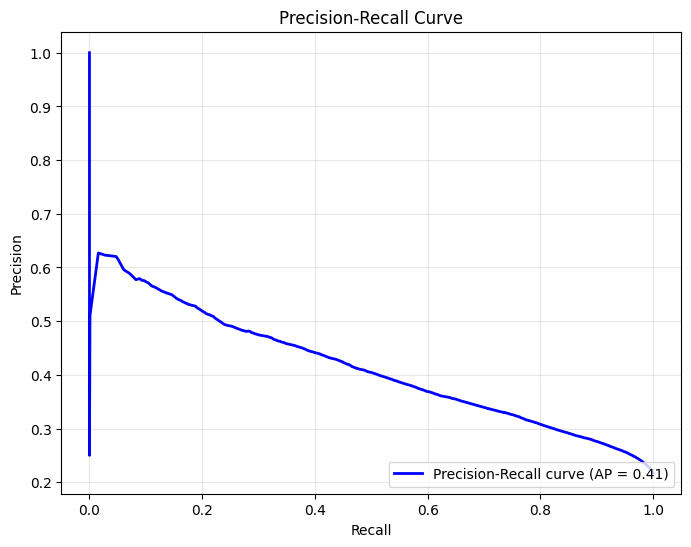

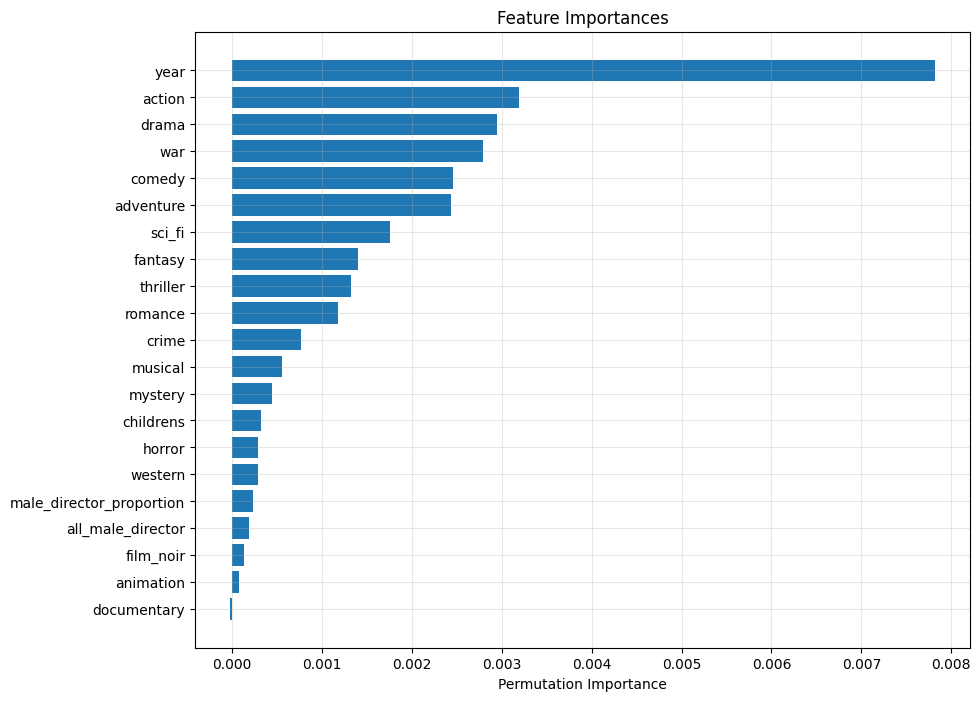

In [36]:
# ROC-AUC Curve
fpr, tpr, _ = roc_curve(y_test, best_rf_model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
# Customize grid lines
plt.grid(alpha=0.3)
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, best_rf_model.predict_proba(X_test)[:, 1])
average_precision = average_precision_score(y_test, best_rf_model.predict_proba(X_test)[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (AP = {:.2f})'.format(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower right')
# Customize grid lines
plt.grid(alpha=0.3)
plt.show()

# Feature Importances
result = permutation_importance(best_rf_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 8))
plt.barh(range(X_test.shape[1]), result.importances_mean[sorted_idx])
plt.yticks(range(X_test.shape[1]), X_test.columns[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Feature Importances')
# Customize grid lines
plt.grid(alpha=0.3)
plt.show()

1. ROC-AUC Curve: Visualizes the trade-off between true positive rate and false positive rate.
- The ROC-AUC score ranges from 0 to 1.
- An AUC of 0.72 suggests a moderate discriminatory power of our model.
A higher ROC-AUC indicates better separation between the positive and negative classes.
A rule of thumb for interpretation:
0.5-0.6: Poor
0.6-0.7: Fair
0.7-0.8: Good
0.8-0.9: Very good
0.9-1.0: Excellent

2. Precision-Recall Curve: Shows the precision-recall trade-off, often useful for imbalanced datasets.
- The Precision-Recall AUC score also ranges from 0 to 1.
- An AP of 0.41 suggests that the precision-recall trade-off might not be ideal, and there's room for improvement.
- Precision-Recall AUC is particularly useful when dealing with imbalanced datasets, focusing on the positive class.

3. Feature Importances Bar Plot: Displays the importance of each feature in the trained Random Forest model.

#### Recommender System using Jaccard Similarity
- In this recommender system, a Movie-User matrix is created based on user ratings. The recommendation algorithm relies on Jaccard similarity between movies to generate personalized recommendations for a user. The generate_movie_recommendations function identifies movies already rated by the user and calculates Jaccard similarity with other movies, considering user preferences. The resulting recommendations are then filtered and ranked by Jaccard similarity. To assess potential bias, one would need to analyze whether the recommended movies exhibit any bias toward director gender, as this information is not explicitly integrated into the recommendation process. Evaluating the fairness and potential bias in movie recommendations would involve examining the recommended movies in relation to the director's gender.

In [37]:
# Create a Movie-User matrix
movie_user_matrix = Ratings_and_Movies.pivot_table(index='movie_id', columns='user_id', values='user_rating', fill_value=0)

# Function to calculate Jaccard similarity between two movies
def calculate_jaccard_similarity(movie1, movie2):
    intersection = sum((movie1 > 0) & (movie2 > 0))
    union = sum((movie1 > 0) | (movie2 > 0))
    
    if union == 0:
        return 0
    
    return intersection / union

# Function to generate movie recommendations based on Jaccard similarity
def generate_movie_recommendations(user_id, movie_user_matrix, df_movies, top_n=5):
    # Get movies already rated by the user
    user_rated_movies = movie_user_matrix[user_id][movie_user_matrix[user_id] > 0].index
    
    # Initialize an empty DataFrame to store recommendations
    recommendations = pd.DataFrame(columns=['movie_id'])
    
    for movie_id in user_rated_movies:
        target_movie_ratings = movie_user_matrix.loc[movie_id]
        similarities = movie_user_matrix.apply(lambda x: calculate_jaccard_similarity(target_movie_ratings, x), axis=1)
    
        # Sort movies by Jaccard similarity in descending order
        similar_movies = similarities.sort_values(ascending=False)
    
        # Exclude movies already rated by the user
        similar_movies = similar_movies.drop(user_rated_movies)
    
        # Append recommendations to the DataFrame
        recommendations = pd.concat([recommendations, similar_movies.head(top_n).reset_index()], ignore_index=True)
    
    # Drop duplicates and keep the top N recommendations
    recommendations = recommendations.drop_duplicates().head(top_n)
    
    # Rename the column '0' to 'Jaccard_Score'
    recommendations = recommendations.rename(columns={0: 'Jaccard_Similarity'})
    
    return recommendations

#### Find top 10 movies for any given user ID

In [38]:
# Example: Recommend top 10 movies for User ID 1
user_id_to_recommend = 1
recommended_movies = generate_movie_recommendations(user_id_to_recommend, movie_user_matrix, Ratings_and_Movies[['movie_id']], top_n=10)

print(f"Top 10 Recommended Movies for User ID {user_id_to_recommend}:\n", recommended_movies)

Top 10 Recommended Movies for User ID 1:
   movie_id  Jaccard_Similarity
0     1265            0.459450
1      356            0.403549
2     1580            0.394260
3     2396            0.382033
4     1196            0.379151
5     1923            0.370974
6     1198            0.363528
7      589            0.360783
8      296            0.360666
9     2716            0.359949


#### Plotted director gender proportion of top 10 movies recommended to user

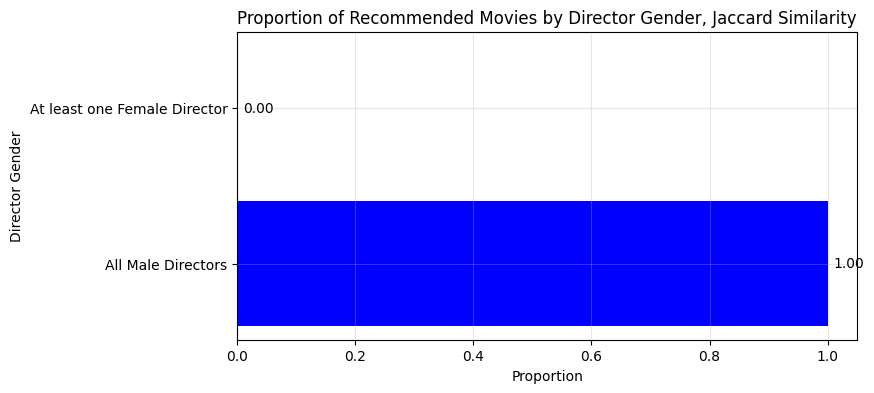

In [39]:
# Calculate the proportion of movies with all male directors
all_male_director_proportion = Ratings_and_Movies[Ratings_and_Movies['movie_id'].isin(list(recommended_movies['movie_id']))]['all_male_director'].mean()

# Calculate the proportion of movies with female directors
female_director_proportion = 1 - all_male_director_proportion

# Data for the horizontal bar chart
labels = ['All Male Directors', 'At least one Female Director']
proportions = [all_male_director_proportion, female_director_proportion]

# Plotting the horizontal bar chart
plt.figure(figsize=(8, 4))
plt.barh(labels, proportions, color=['blue', '#FF69B4'])
plt.title('Proportion of Recommended Movies by Director Gender, Jaccard Similarity')
plt.xlabel('Proportion')
plt.ylabel('Director Gender')

# Adding values to the bars
for i, proportion in enumerate(proportions):
    plt.text(proportion + 0.01, i, f'{proportion:.2f}', va='center')

# Customize grid lines
plt.grid(alpha=0.3)

# Show plot
plt.show()

#### Plotted director gender proportion based on user's watch history

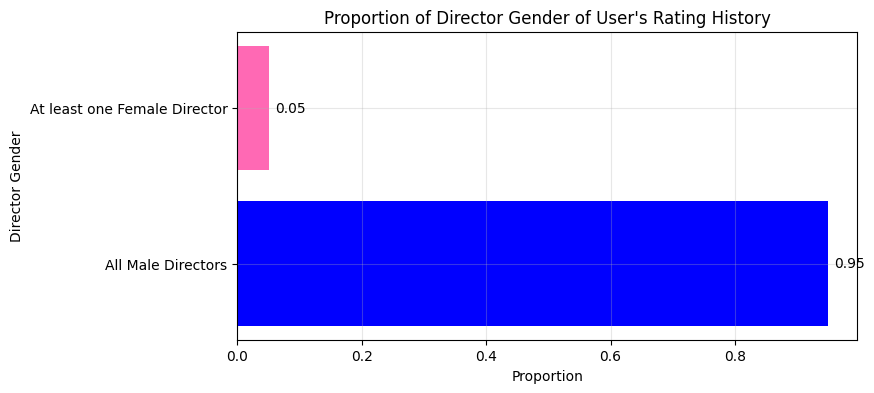

In [40]:
# Calculate the proportion of movies with all male directors for the user's rating history
all_male_director_proportion = Ratings_and_Movies[Ratings_and_Movies['user_id'] == user_id_to_recommend]['all_male_director'].mean()

# Calculate the proportion of movies with female directors
female_director_proportion = 1 - all_male_director_proportion

# Data for the horizontal bar chart
labels = ['All Male Directors', 'At least one Female Director']
proportions = [all_male_director_proportion, female_director_proportion]

# Plotting the horizontal bar chart
plt.figure(figsize=(8, 4))
plt.barh(labels, proportions, color=['blue', '#FF69B4'])
plt.title("Proportion of Director Gender of User's Rating History")
plt.xlabel('Proportion')
plt.ylabel('Director Gender')

# Adding values to the bars
for i, proportion in enumerate(proportions):
    plt.text(proportion + 0.01, i, f'{proportion:.2f}', va='center')

# Customize grid lines
plt.grid(alpha=0.3)

# Show plot
plt.show()

#### Analysis:
- Top 10 recommended movies so far do not appear to provide diverse suggestions. After analyzing one user, it was observed that all recommended movies are directed by males, potentially introducing bias and overlooking potentially good recommendations directed by females. We plotted the user's watch history to determine the percentage of movies they watched that included female directors, which, for this user, is 0.5%. However, it is crucial to understand why solely male-directed movies are being recommended when director gender should not be a factor in detracting recommendations.

#### Recommender System using Cosine Similarity

We investigate whether recommender systems using different similarity measures are able to provide more diverse recommendations. We look at Cosine Similarity, a popular measure for capturing nuanced relationships between items and users, particularly in high-dimensional spaces.

Cosine similarity evaluates the similarity between movies based on the cosine of the angle between their respective feature vectors, representing user ratings. The higher the cosine similarity value, the more alike two movies are considered to be in terms of user ratings.

To generate movie recommendations for a given user using Cosine similarity, the model takes the unique user ID, a matrix representing user-movie ratings, the movie information, and the desired number of top recommendations (top_n). It first identifies movies already rated by the user, then computes the similarity between each of these rated movies and all other movies in the dataset. Based on the Cosine similarity scores, it selects the top N movies as recommendations, excluding those already rated by the user.

In [41]:
# Function to calculate Cosine similarity between two movies
def calculate_cosine_similarity(movie1, movie2):
    return cosine_similarity([movie1], [movie2])[0][0]

# Function to generate movie recommendations based on Cosine similarity
def generate_movie_recommendations_cosine(user_id, movie_user_matrix, df_movies, top_n=5):
    # Get movies already rated by the user
    user_rated_movies = movie_user_matrix[user_id][movie_user_matrix[user_id] > 0].index
    
    # Initialize an empty DataFrame to store recommendations
    recommendations = pd.DataFrame(columns=['movie_id'])
    
    for movie_id in user_rated_movies:
        target_movie_ratings = movie_user_matrix.loc[movie_id]
        similarities = movie_user_matrix.apply(lambda x: calculate_cosine_similarity(target_movie_ratings, x), axis=1)
    
        # Sort movies by Cosine similarity in descending order
        similar_movies = similarities.sort_values(ascending=False)
    
        # Exclude movies already rated by the user
        similar_movies = similar_movies.drop(user_rated_movies)
    
        # Append recommendations to the DataFrame
        recommendations = pd.concat([recommendations, similar_movies.head(top_n).reset_index()], ignore_index=True)
    
    # Drop duplicates and keep the top N recommendations
    recommendations = recommendations.drop_duplicates().head(top_n)
    
    # Rename the column '0' to 'Cosine_Similarity'
    recommendations = recommendations.rename(columns={0: 'Cosine_Similarity'})
    
    return recommendations

# Example usage
user_id_to_recommend = 1
top_recommendations_cosine = generate_movie_recommendations_cosine(user_id_to_recommend, movie_user_matrix, Ratings_and_Movies[['movie_id']], top_n=10)
print(f"Top 10 Recommended Movies (Cosine) for User ID {user_id_to_recommend}:\n", top_recommendations_cosine)

Top 10 Recommended Movies (Cosine) for User ID 1:
   movie_id  Cosine_Similarity
0     1265           0.610826
1     1196           0.552856
2     1580           0.552362
3      356           0.551034
4     2396           0.533700
5     1198           0.530881
6     1923           0.523675
7     1210           0.521209
8     2716           0.519305
9      589           0.515537


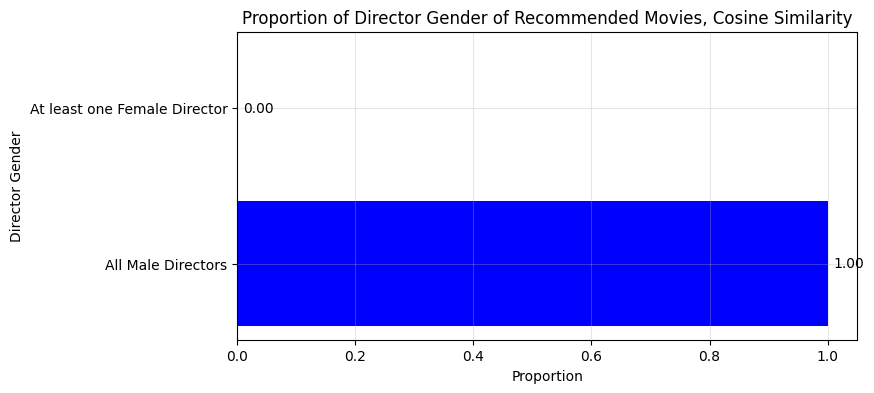

In [42]:
# Calculate mean male director proportion of recommended movies using cosine similarity
all_male_director_proportion_cosine = Ratings_and_Movies[Ratings_and_Movies['movie_id'].isin(list(top_recommendations_cosine['movie_id']))]['all_male_director'].mean()

# Calculate female director proportion
female_director_proportion_cosine = 1 - all_male_director_proportion_cosine

# Data for the horizontal bar chart
labels = ['All Male Directors', 'At least one Female Director']
proportions = [all_male_director_proportion_cosine, female_director_proportion_cosine]

# Plotting the horizontal bar chart
plt.figure(figsize=(8, 4))
plt.barh(labels, proportions, color=['blue', '#FF69B4'])
plt.title('Proportion of Director Gender of Recommended Movies, Cosine Similarity')
plt.xlabel('Proportion')
plt.ylabel('Director Gender')

# Adding values to the bars
for i, proportion in enumerate(proportions):
    plt.text(proportion + 0.01, i, f'{proportion:.2f}', va='center')

# Customize grid lines
plt.grid(alpha=0.3)

# Show plot
plt.show()

The model's diversity in director genders of recommended movies was worse than the model using Jaccard Similarity, as all movie recommendations are fully directed by males.

Analysis:
- Top 10 recommended movies so far do not appear to provide diverse suggestions. After analyzing one user, it was observed that all recommended movies are directed by males, potentially introducing bias and overlooking potentially good recommendations directed by females. We plotted the user's watch history to determine the percentage of movies they watched that included female directors, which, for this user, is 0.5%. However, it is crucial to understand why solely male-directed movies are being recommended when director gender should not be a factor in detracting recommendations.

#### Recommender System using Pearson Correlation

Pearson correlation is a different metric that is often used to capture linear relationships between variables.

This approach measures the linear correlation between two movies based on the ratings provided by users. A higher Pearson correlation indicates greater similarity in user ratings between two movies. It first identifies the common users who have rated both movies, then computes the correlation coefficient based on their ratings. If there are no common users, the correlation is considered to be zero.

The recommender system identifies movies already rated by the user, computes the Pearson correlation between each of these rated movies and all other movies in the dataset, and selects the top N movies with the highest correlation to reccomend, excluding those already rated by the user.

In [43]:
# Function to calculate Pearson correlation between two movies
def calculate_pearson_correlation(movie1, movie2):
    common_users = movie1.index.intersection(movie2.index)
    
    if len(common_users) == 0:
        return 0
    
    rating1 = movie1[common_users]
    rating2 = movie2[common_users]
    
    correlation, _ = pearsonr(rating1, rating2)
    return correlation

# Function to generate movie recommendations based on Pearson correlation
def generate_movie_recommendations_pearson(user_id, movie_user_matrix, df_movies, top_n=5):
    # Get movies already rated by the user
    user_rated_movies = movie_user_matrix[user_id][movie_user_matrix[user_id] > 0].index
    
    # Initialize an empty DataFrame to store recommendations
    recommendations = pd.DataFrame(columns=['movie_id'])
    
    for movie_id in user_rated_movies:
        target_movie_ratings = movie_user_matrix.loc[movie_id]
        similarities = movie_user_matrix.apply(lambda x: calculate_pearson_correlation(target_movie_ratings, x), axis=1)
    
        # Sort movies by Pearson correlation in descending order
        similar_movies = similarities.sort_values(ascending=False)
    
        # Exclude movies already rated by the user
        similar_movies = similar_movies.drop(user_rated_movies)
    
        # Append recommendations to the DataFrame
        recommendations = pd.concat([recommendations, similar_movies.head(top_n).reset_index()], ignore_index=True)
    
    # Drop duplicates and keep the top N recommendations
    recommendations = recommendations.drop_duplicates().head(top_n)
    
    # Rename the column '0' to 'Pearson_Correlation'
    recommendations = recommendations.rename(columns={0: 'Pearson_Correlation'})
    
    return recommendations

# Example usage
user_id_to_recommend = 1 
top_recommendations_pearson = generate_movie_recommendations_pearson(user_id_to_recommend, movie_user_matrix, Ratings_and_Movies[['movie_id']], top_n=10)
print(f"Top 10 Recommended Movies (Pearson) for User ID {user_id_to_recommend}:\n", top_recommendations_pearson)

Top 10 Recommended Movies (Pearson) for User ID 1:
   movie_id  Pearson_Correlation
0     1265             0.407547
1     3253             0.370424
2     1923             0.357726
3     1517             0.347186
4       39             0.326788
5     1500             0.325082
6      356             0.323808
7      500             0.308802
8     2174             0.306969
9      586             0.302354


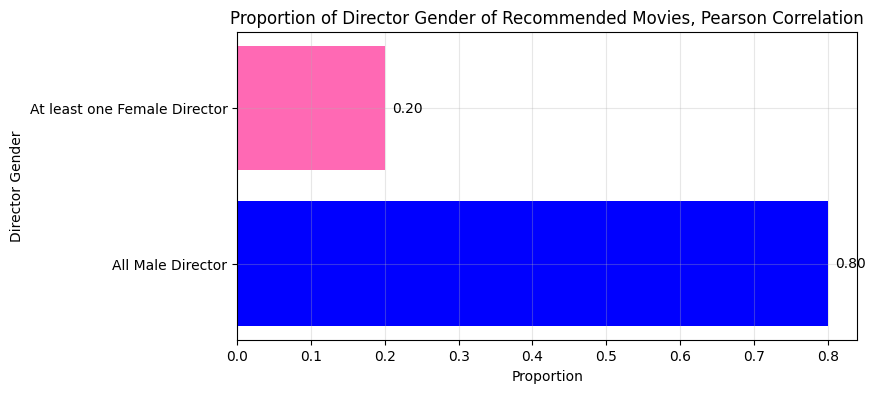

In [44]:
# Calculate mean male director proportion of recommended movies
all_male_director_proportion_pearson = Ratings_and_Movies[Ratings_and_Movies['movie_id'].isin(list(top_recommendations_pearson['movie_id']))].drop_duplicates(subset='movie_id')['all_male_director'].mean()

# Calculate female director proportion
female_director_proportion_pearson = 1 - all_male_director_proportion_pearson

# Data for the horizontal bar chart
labels = ['All Male Director', 'At least one Female Director']
proportions = [all_male_director_proportion_pearson, female_director_proportion_pearson]

# Plotting the horizontal bar chart
plt.figure(figsize=(8, 4))
plt.barh(labels, proportions, color=['blue', '#FF69B4'])
plt.title('Proportion of Director Gender of Recommended Movies, Pearson Correlation')
plt.xlabel('Proportion')
plt.ylabel('Director Gender')

# Adding values to the bars
for i, proportion in enumerate(proportions):
    plt.text(proportion + 0.01, i, f'{proportion:.2f}', va='center')

# Customize grid lines
plt.grid(alpha=0.3)

# Show plot
plt.show()

Recommendations generated by the system using Pearson Correlation exhibited a slight increase in diversity concerning the gender of movie directors compared to the other similarity metrics. Specifically, the recommended movies exhibited an average proportion of female directors of 20%, a notable increase compared to the 5% average observed within the user's watch history. This suggests that the recommender system that uses Pearson Correlation yielded a more inclusive selection of movies, showcasing a greater representation of films directed by women.

#### Recommender System using Singular Value Decomposition

From the Surprise machine learning toolkit, Singular Value Decomposition (SVD) is a Matrix Factorization-based algorithm that often captures latent factors underlying user preferences. The recommender model uses an SVD object, which is trained on the training dataset to optimize predictive performance using user-item interactions.

In [45]:
# Create a Surprise Reader object
reader = Reader(rating_scale=(1, 5))

# Load data from DataFrame to Surprise Dataset
data = Dataset.load_from_df(Ratings_and_Movies[['user_id', 'movie_id', 'user_rating']], reader)

# Split the data into train and test sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Initialize the SVD algorithm
svd = SVD()

# Train the algorithm on the training set
svd.fit(trainset)

# Evaluate the algorithm using cross-validation
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8821  0.8743  0.8798  0.8794  0.8818  0.8795  0.0028  
MAE (testset)     0.6939  0.6898  0.6924  0.6931  0.6949  0.6928  0.0017  
Fit time          3.34    3.76    3.48    3.18    3.08    3.37    0.24    
Test time         0.52    0.52    0.21    0.50    0.21    0.39    0.15    


{'test_rmse': array([0.88213734, 0.87431873, 0.87979868, 0.87940272, 0.88182017]),
 'test_mae': array([0.69391498, 0.68980903, 0.6924487 , 0.69310891, 0.69487232]),
 'fit_time': (3.339521884918213,
  3.756572961807251,
  3.4761240482330322,
  3.1819369792938232,
  3.079845666885376),
 'test_time': (0.516589879989624,
  0.5192549228668213,
  0.21361088752746582,
  0.5048990249633789,
  0.21130800247192383)}

In [46]:
# Example: Make a prediction for user 1, movie 302
user_id_to_predict = 1
movie_id_to_predict = 302

# Get the prediction
prediction = svd.predict(user_id_to_predict, movie_id_to_predict, 3)

# Round the prediction before printing
rounded_prediction = round(prediction.est)

# Print the rounded prediction details
print(f"Prediction for user {user_id_to_predict}, movie {movie_id_to_predict}: {rounded_prediction}")

Prediction for user 1, movie 302: 4


In [47]:
user_id_to_predict = 1

# Filter Ratings_and_Movies DataFrame for a specific user
user_ratings = Ratings_and_Movies[Ratings_and_Movies['user_id'] == user_id_to_predict]

# Iterate over the user's rated movies and make predictions
for _, row in user_ratings.iterrows():
    movie_id_to_predict = row['movie_id']
    
    # Get the prediction
    prediction = svd.predict(user_id_to_predict, movie_id_to_predict, 3)
    
    # Round the prediction before printing
    rounded_prediction = round(prediction.est)
    
    # Print the rounded prediction details
    print(f"Prediction for user {user_id_to_predict}, movie {movie_id_to_predict}: {rounded_prediction}")

Prediction for user 1, movie 1: 5
Prediction for user 1, movie 48: 4
Prediction for user 1, movie 150: 4
Prediction for user 1, movie 260: 5
Prediction for user 1, movie 527: 5
Prediction for user 1, movie 588: 4
Prediction for user 1, movie 594: 4
Prediction for user 1, movie 595: 4
Prediction for user 1, movie 661: 4
Prediction for user 1, movie 914: 4
Prediction for user 1, movie 938: 4
Prediction for user 1, movie 1022: 4
Prediction for user 1, movie 1028: 4
Prediction for user 1, movie 1029: 4
Prediction for user 1, movie 1097: 4
Prediction for user 1, movie 1193: 5
Prediction for user 1, movie 1207: 5
Prediction for user 1, movie 1246: 5
Prediction for user 1, movie 1270: 4
Prediction for user 1, movie 1287: 5
Prediction for user 1, movie 1566: 4
Prediction for user 1, movie 1721: 4
Prediction for user 1, movie 1907: 4
Prediction for user 1, movie 1961: 5
Prediction for user 1, movie 1962: 4
Prediction for user 1, movie 2018: 4
Prediction for user 1, movie 2028: 5
Prediction for 

To assess the predictive accuracy and generalization capability of the model, we use cross-validation. We perform k-fold cross-validation, with k set to 5 for robustness. The model's performance is evaluated using Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE). These metrics provide insights into the model's ability to accurately predict user ratings and its overall performance across different folds of the dataset.

In [48]:
# Create a Surprise Reader object
reader = Reader(rating_scale=(1, 5))

# Load data from DataFrame to Surprise Dataset
data = Dataset.load_from_df(Ratings_and_Movies[['user_id', 'movie_id', 'user_rating']], reader)

# Split the data into train and test sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Initialize the SVD algorithm
svd = SVD()

# Train the algorithm on the training set
svd.fit(trainset)

# Get all unique user IDs
all_user_ids = Ratings_and_Movies['user_id'].unique()

# Initialize an empty list to store predictions
all_predictions = []

# Iterate through all user IDs and make predictions for all movies
for user_id_to_predict in all_user_ids:
    all_movie_ids = Ratings_and_Movies['movie_id'].unique()
    predictions = [(user_id_to_predict, movie_id, svd.predict(user_id_to_predict, movie_id).est) for movie_id in all_movie_ids]
    all_predictions.extend(predictions)

# Create a DataFrame from all predictions and round the 'predicted_rating' column
predictions_df = pd.DataFrame(all_predictions, columns=['user_id', 'movie_id', 'predicted_rating'])
predictions_df['predicted_rating'] = predictions_df['predicted_rating'].round()

# Include 'all_male_director' from Ratings_and_Movies DataFrame
predictions_df = pd.merge(predictions_df, Ratings_and_Movies[['user_id', 'movie_id', 'all_male_director']], on=['user_id', 'movie_id'])

print(predictions_df)

# Define protected attributes
protected_attributes = ['all_male_director']

# Define favorable classes (e.g., high ratings)
favorable_classes = [5]

# Create a StandardDataset for AIF360
aif360_dataset = StandardDataset(predictions_df, label_name='predicted_rating', favorable_classes=favorable_classes,
                                  protected_attribute_names=protected_attributes,
                                  privileged_classes=[[1]])

# Calculate disparate impact before any mitigation
metric_before = BinaryLabelDatasetMetric(aif360_dataset, unprivileged_groups=[{'all_male_director': 0}],
                                         privileged_groups=[{'all_male_director': 1}])
disparate_impact_before = metric_before.disparate_impact()

print("Disparate Impact Before Mitigation:", disparate_impact_before)
print("Statistical Parity Difference Before Mitigation:", metric_before.statistical_parity_difference())

        user_id  movie_id  predicted_rating  all_male_director
0             1         1               5.0                1.0
1             1        48               4.0                1.0
2             1       150               5.0                1.0
3             1       260               5.0                1.0
4             1       527               5.0                1.0
...         ...       ...               ...                ...
597312      745      3915               2.0                0.0
597313      745      3916               3.0                1.0
597314      745      3946               3.0                1.0
597315      745      3948               4.0                1.0
597316      745      3950               4.0                1.0

[597317 rows x 4 columns]
Disparate Impact Before Mitigation: 0.38598549335601495
Statistical Parity Difference Before Mitigation: -0.05295653546051634


In [49]:
# Make predictions on the test set
predictions = svd.test(testset)

# Calculate and print the RMSE (Root Mean Squared Error) on the test set
rmse_before = accuracy.rmse(predictions)
print("RMSE Before Mitigation:", rmse_before)

# Calculate and print the MAE (Mean Absolute Error) on the test set
mae_before = accuracy.mae(predictions)
print("MAE Before Mitigation:", mae_before)

RMSE: 0.8815
RMSE Before Mitigation: 0.8814525834539915
MAE:  0.6939
MAE Before Mitigation: 0.6939024411599718


Bias metrics:
- Disparate Impact Before Mitigation: ~0.40
    - This metric indicates a significant disparity in favorable outcomes between movies directed by males and those directed by females, with a value of ~0.40 suggesting unequal representation in the recommended items.

- Statistical Parity Difference Before Mitigation: -0.052
    - The negative value of -0.052 indicates a bias favoring movies directed by females in receiving favorable outcomes, further highlighting the imbalance in recommendations.

Utility:
- RMSE (Root Mean Squared Error) Before Mitigation: 0.8802
    - The RMSE value of 0.8802 signifies the average discrepancy between predicted and actual ratings, reflecting the prediction accuracy of the model in prioritizing male-directed content.

- MAE (Mean Absolute Error) Before Mitigation: 0.6937
    - With an MAE value of 0.6937, the model's average deviation from actual ratings is approximately 0.6937 units, providing insight into prediction accuracy without considering the direction of errors.

### [4.](#Table-of-Contents) Bias Mitigation 

#### Random Forest Pre-Processing Bias Mitigation 
- In this code, a pre-processing technique called reweighing is employed as a bias mitigation strategy. Initially, a Random Forest Classifier is trained on the original dataset, and its predictions are evaluated for bias using metrics like Disparate Impact and Statistical Parity Difference. Subsequently, the dataset is reweighed using the Reweighing technique, which adjusts the instance weights to mitigate bias. A new Random Forest Classifier is then trained on the reweighed dataset, and its performance and bias metrics are assessed. This approach aims to address potential bias in the original model's predictions by reweighing instances based on the protected attribute 'all_male_director' before retraining the model.

In [50]:
# Suppress specific warning
warnings.filterwarnings("ignore", message="`load_boston` has been removed from scikit-learn since version 1.2.")

# Features and target variable
X = Ratings_and_Movies[['year', 'documentary', 'romance', 'fantasy', 'western', 'thriller',
                         'childrens', 'film_noir', 'drama', 'comedy', 'adventure', 'horror', 'crime', 
                         'action', 'mystery', 'war', 'musical', 'animation', 'sci_fi', 'male_director_proportion', 'all_male_director']]
y = (Ratings_and_Movies['user_rating'] == 5).astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = sklearn_train_test_split(X, y, test_size=0.2, random_state=42)

# Define the protected attributes
protected_attributes = ['all_male_director']

# Define the privileged and unprivileged groups
privileged_groups = [{'all_male_director': 1}]
unprivileged_groups = [{'all_male_director': 0}]

# Initialize the Random Forest Classifier model with n_estimators=100
rf_classifier_before = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the original classifier on the original dataset
rf_classifier_before.fit(X_train, y_train)

# Make predictions on the test data using the original model
y_pred_rf_before = rf_classifier_before.predict(X_test)

# Calculate accuracy using scikit-learn's accuracy_score on the original dataset
accuracy_rf_before = accuracy_score(y_test, y_pred_rf_before)

# Combine X_test, y_test, and y_pred_rf_before into a new DataFrame
test_results_before = pd.concat([X_test, pd.DataFrame({'user_rating': y_test, 'predicted_rating': y_pred_rf_before})], axis=1)

# Extract the protected attribute 'director_gender' from the original dataset
test_results_before['all_male_director'] = Ratings_and_Movies.loc[X_test.index, 'all_male_director']

# Create a StandardDataset
dataset_before = StandardDataset(df=test_results_before,
                                  label_name='user_rating', favorable_classes=[1],
                                  protected_attribute_names=protected_attributes,
                                  privileged_classes=[[1]])  # Only one class for all_male_director (e.g., male is privileged)

# Use reweighing to adjust weights
reweighing = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
dataset_reweighed = reweighing.fit_transform(dataset_before)

# Create a BinaryLabelDatasetMetric for bias metrics on the reweighed dataset
dataset_metric_before = BinaryLabelDatasetMetric(dataset_before, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
dataset_metric_reweighed = BinaryLabelDatasetMetric(dataset_reweighed, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

# Display bias metrics before reweighing
display(Markdown("#### Bias Metrics before Reweighing"))
print("Disparate Impact:", dataset_metric_before.disparate_impact())
print("Statistical Parity Difference:", dataset_metric_before.statistical_parity_difference())

# Display accuracy before reweighing
display(Markdown("#### Accuracy before Reweighing"))
print("Accuracy before Reweighing:", accuracy_rf_before)

# Initialize a new Random Forest Classifier model with same n_estimators=100
rf_classifier_reweighed = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the new classifier on the reweighed dataset
rf_classifier_reweighed.fit(dataset_reweighed.features, dataset_reweighed.labels.ravel(), sample_weight=dataset_reweighed.instance_weights)

# Make predictions on the reweighed test data using the new model
y_pred_rf_reweighed = rf_classifier_reweighed.predict(dataset_reweighed.features)

# Calculate accuracy using scikit-learn's accuracy_score on the reweighed dataset
accuracy_rf_reweighed = accuracy_score(dataset_reweighed.labels, y_pred_rf_reweighed)

# Create a BinaryLabelDatasetMetric for bias metrics on the retrained model
dataset_retrained_metric = BinaryLabelDatasetMetric(dataset_reweighed, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

# Display Random Forest Classifier Metrics after retraining on reweighed data
display(Markdown("#### Random Forest Classifier Metrics after Retraining on Reweighed Data"))
print("n_estimators:", rf_classifier_reweighed.n_estimators)
print("Accuracy after Reweighing:", accuracy_rf_reweighed)
print("\nClassification Report after Reweighing:\n", classification_report(dataset_reweighed.labels, y_pred_rf_reweighed))

# Display bias metrics after retraining
display(Markdown("#### Bias Metrics after Retraining"))
print("Disparate Impact:", dataset_retrained_metric.disparate_impact())
print("Statistical Parity Difference:", dataset_retrained_metric.statistical_parity_difference())

#### Bias Metrics before Reweighing

Disparate Impact: 0.6683266010922667
Statistical Parity Difference: -0.07358900435300986


#### Accuracy before Reweighing

Accuracy before Reweighing: 0.7880449340387062


#### Random Forest Classifier Metrics after Retraining on Reweighed Data

n_estimators: 100
Accuracy after Reweighing: 0.7879947097033416

Classification Report after Reweighing:
               precision    recall  f1-score   support

         0.0       0.80      0.97      0.88     93464
         1.0       0.56      0.12      0.20     26000

    accuracy                           0.79    119464
   macro avg       0.68      0.55      0.54    119464
weighted avg       0.75      0.79      0.73    119464



#### Bias Metrics after Retraining

Disparate Impact: 0.9999999999999998
Statistical Parity Difference: -5.551115123125783e-17


- Before reweighing, the original Random Forest Classifier exhibited bias with a Disparate Impact of 0.668 and a Statistical Parity Difference of -0.0736. The accuracy before reweighing was 0.788. After retraining on the reweighed data, the Random Forest Classifier with 100 estimators achieved an accuracy of 0.788, showing a slight decrease in accuracy. The bias metrics also improved significantly, with the Disparate Impact being approximately 1 and the Statistical Parity Difference close to zero (-5.551115123125783e-17). The classification report after reweighing indicated precision of 0.56, recall of 0.12, and an F1-score of 0.20 for the positive class (user rating of 5), with a slight decrease in overall accuracy. This suggests that the reweighing technique successfully mitigated bias, resulting in a fairer model while maintaining similar predictive accuracy.

#### Recommender System Bias Mitigation (Jaccard Similarity) - Using Reweighed Dataset

AIF360's reweighing technique helps mitigate bias present in the original dataset by adjusting the weights of instances based on sensitive attributes such as director gender. By doing so, it aims to ensure fairness by reducing the influence of biased features on the learning process.

The original dataset exhibits bias towards male-directed content through the underrepresentation of female directors, leading to a disproportionate representation of such movies in the recommendations. AIF360's reweighing technique helps mitigate this bias by adjusting the weights of movie instances based on director gender, ensuring a more balanced representation of both male and female-directed content.

The similarity metrics used in our recommender models above (Jaccard, Cosine, and Pearson correlation) rely on the dataset to calculate similarities between movies. Since the dataset exhibits bias towards male-directed content, these similarity metrics also favor male-directed movies in recommendations. By applying reweighing, the transformed dataset aims to mitigate such bias, ensuring that similarity calculations consider a more balanced representation of movies directed by individuals of different genders. As such, we develop the models again using the same similarity metrics on the transformed dataset.

In [51]:
# Define protected attributes
protected_attributes = ['all_male_director']

# Define favorable classes (e.g., high ratings)
favorable_classes = [5]

Ratings_and_Movies['user_rating_copy'] = Ratings_and_Movies['user_rating']

# Create a StandardDataset for AIF360
aif360_dataset_original = StandardDataset(Ratings_and_Movies, label_name='user_rating', favorable_classes=favorable_classes,
                                  protected_attribute_names=protected_attributes,
                                  privileged_classes=[[1]])

# Apply Reweighing as a bias mitigation technique
rw = Reweighing(unprivileged_groups=[{'all_male_director': 0}], privileged_groups=[{'all_male_director': 1}])
aif360_dataset_reweighed = rw.fit_transform(aif360_dataset_original)

# Convert StandardDataset to DataFrame
aif360_df_reweighed = aif360_dataset_reweighed.convert_to_dataframe()[0]

# Extract relevant columns from the original dataset
original_df_reweighed = aif360_df_reweighed[['movie_id', 'user_id', 'user_rating_copy']]

# Create a Movie-User matrix from the original dataset
movie_user_matrix_reweighed = original_df_reweighed.pivot_table(index='movie_id', columns='user_id', values='user_rating_copy', fill_value=0)

In [52]:
def generate_movie_recommendations_reweighed(user_id, movie_user_matrix_reweighed, df_movies, top_n=10):
    # Get movies already rated by the user
    user_rated_movies = movie_user_matrix_reweighed[user_id][movie_user_matrix_reweighed[user_id] > 0].index
    
    # Initialize an empty DataFrame to store recommendations
    recommendations = pd.DataFrame(columns=['movie_id'])
    
    for movie_id in user_rated_movies:
        target_movie_ratings = movie_user_matrix_reweighed.loc[movie_id]
        similarities = movie_user_matrix_reweighed.apply(lambda x: calculate_jaccard_similarity(target_movie_ratings, x), axis=1)
    
        # Sort movies by Jaccard similarity in descending order
        similar_movies = similarities.sort_values(ascending=False)
    
        # Exclude movies already rated by the user
        similar_movies = similar_movies.drop(user_rated_movies)
    
        # Append recommendations to the DataFrame
        recommendations = pd.concat([recommendations, similar_movies.head(top_n).reset_index()], ignore_index=True)
    
    # Drop duplicates and keep the top N recommendations
    recommendations = recommendations.drop_duplicates().head(top_n)
    
    # Rename the column '0' to 'Jaccard_Similarity'
    recommendations = recommendations.rename(columns={0: 'Jaccard_Similarity'})
    
    return recommendations

# Example usage
user_id_to_recommend = 1 
top_recommendations_reweighed = generate_movie_recommendations_reweighed(user_id_to_recommend, movie_user_matrix_reweighed, original_df_reweighed[['movie_id']], top_n=10)
print(f"Top 10 Recommended Movies (Reweighted) for User ID {user_id_to_recommend}:\n", top_recommendations_reweighed)

Top 10 Recommended Movies (Reweighted) for User ID 1:
    movie_id  Jaccard_Similarity
0    1265.0            0.459450
1     356.0            0.403549
2    1580.0            0.394260
3    2396.0            0.382033
4    1196.0            0.379151
5    1923.0            0.370974
6    1198.0            0.363528
7     589.0            0.360783
8     296.0            0.360666
9    2716.0            0.359949


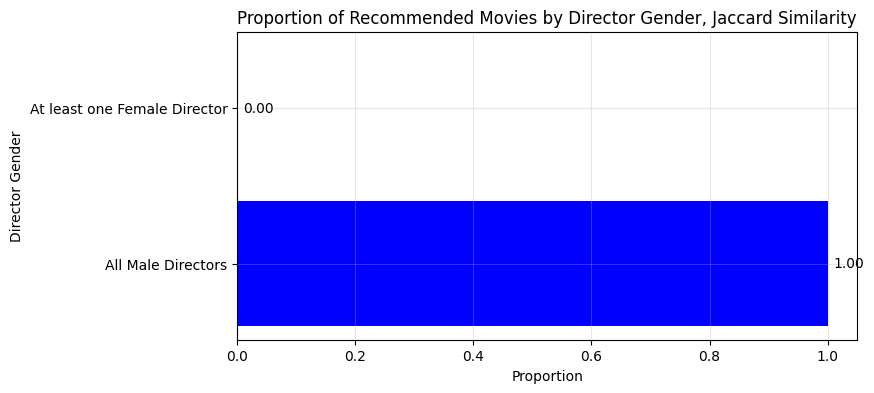

In [53]:
# Calculate the proportion of movies with all male directors
all_male_director_proportion = Ratings_and_Movies[Ratings_and_Movies['movie_id'].isin(list(top_recommendations_reweighed['movie_id']))]['all_male_director'].mean()

# Calculate the proportion of movies with female directors
female_director_proportion = 1 - all_male_director_proportion

# Data for the horizontal bar chart
labels = ['All Male Directors', 'At least one Female Director']
proportions = [all_male_director_proportion, female_director_proportion]

# Plotting the horizontal bar chart
plt.figure(figsize=(8, 4))
plt.barh(labels, proportions, color=['blue', '#FF69B4'])
plt.title('Proportion of Recommended Movies by Director Gender, Jaccard Similarity')
plt.xlabel('Proportion')
plt.ylabel('Director Gender')

# Adding values to the bars
for i, proportion in enumerate(proportions):
    plt.text(proportion + 0.01, i, f'{proportion:.2f}', va='center')

# Customize grid lines
plt.grid(alpha=0.3)

# Show plot
plt.show()

#### Recommender System Bias Mitigation (Cosine Similarity) - Using Reweighed Dataset¶

In [54]:
# Function to calculate Cosine similarity between two movies
def calculate_cosine_similarity(movie1, movie2):
    return cosine_similarity([movie1], [movie2])[0][0]

# Function to generate movie recommendations based on Cosine similarity
def generate_movie_recommendations_cosine(user_id, movie_user_matrix, df_movies, top_n=5):
    # Get movies already rated by the user
    user_rated_movies = movie_user_matrix[user_id][movie_user_matrix[user_id] > 0].index
    
    # Initialize an empty DataFrame to store recommendations
    recommendations = pd.DataFrame(columns=['movie_id'])
    
    for movie_id in user_rated_movies:
        target_movie_ratings = movie_user_matrix.loc[movie_id]
        similarities = movie_user_matrix.apply(lambda x: calculate_cosine_similarity(target_movie_ratings, x), axis=1)
    
        # Sort movies by Cosine similarity in descending order
        similar_movies = similarities.sort_values(ascending=False)
    
        # Exclude movies already rated by the user
        similar_movies = similar_movies.drop(user_rated_movies)
    
        # Append recommendations to the DataFrame
        recommendations = pd.concat([recommendations, similar_movies.head(top_n).reset_index()], ignore_index=True)
    
    # Drop duplicates and keep the top N recommendations
    recommendations = recommendations.drop_duplicates().head(top_n)
    
    # Rename the column '0' to 'Cosine_Similarity'
    recommendations = recommendations.rename(columns={0: 'Cosine_Similarity'})
    
    return recommendations

# Example usage for reweighed dataset
user_id_to_recommend_reweighed = 1 
top_recommendations_reweighed = generate_movie_recommendations_cosine(user_id_to_recommend_reweighed, movie_user_matrix_reweighed, original_df_reweighed[['movie_id']], top_n=10)
print(f"Top 10 Recommended Movies (Cosine - Reweighted) for User ID {user_id_to_recommend_reweighed}:\n", top_recommendations_reweighed)

Top 10 Recommended Movies (Cosine - Reweighted) for User ID 1:
    movie_id  Cosine_Similarity
0    1265.0           0.610826
1    1196.0           0.552856
2    1580.0           0.552362
3     356.0           0.551034
4    2396.0           0.533700
5    1198.0           0.530881
6    1923.0           0.523675
7    1210.0           0.521209
8    2716.0           0.519305
9     589.0           0.515537


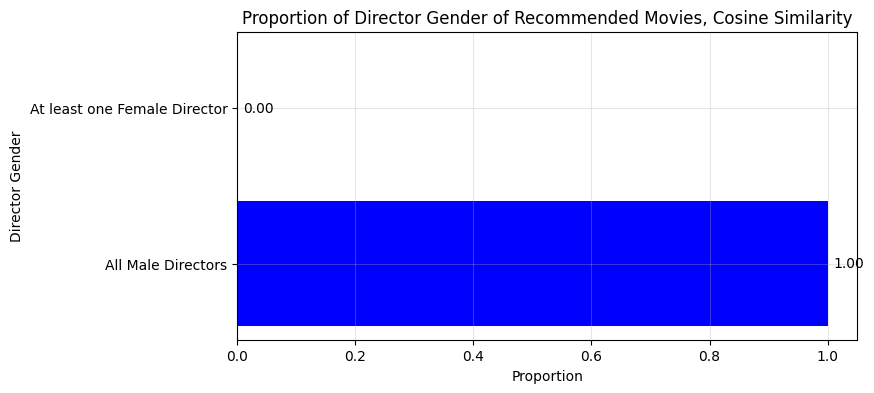

In [55]:
# Calculate mean male director proportion of recommended movies using cosine similarity
all_male_director_proportion_cosine = Ratings_and_Movies[Ratings_and_Movies['movie_id'].isin(list(top_recommendations_reweighed['movie_id']))]['all_male_director'].mean()

# Calculate female director proportion
female_director_proportion_cosine = 1 - all_male_director_proportion_cosine

# Data for the horizontal bar chart
labels = ['All Male Directors', 'At least one Female Director']
proportions = [all_male_director_proportion_cosine, female_director_proportion_cosine]

# Plotting the horizontal bar chart
plt.figure(figsize=(8, 4))
plt.barh(labels, proportions, color=['blue', '#FF69B4'])
plt.title('Proportion of Director Gender of Recommended Movies, Cosine Similarity')
plt.xlabel('Proportion')
plt.ylabel('Director Gender')

# Adding values to the bars
for i, proportion in enumerate(proportions):
    plt.text(proportion + 0.01, i, f'{proportion:.2f}', va='center')

# Customize grid lines
plt.grid(alpha=0.3)

# Show plot
plt.show()

#### Recommender System Bias Mitigation (Pearson) - Using Reweighed Dataset¶

In [56]:
# Function to calculate Pearson correlation between two movies
def calculate_pearson_correlation(movie1, movie2):
    common_users = movie1.index.intersection(movie2.index)
    
    if len(common_users) == 0:
        return 0
    
    rating1 = movie1[common_users]
    rating2 = movie2[common_users]
    
    correlation, _ = pearsonr(rating1, rating2)
    return correlation

# Function to generate movie recommendations based on Pearson correlation
def generate_movie_recommendations_pearson_reweighed(user_id, movie_user_matrix_reweighed, df_movies, top_n=10):
    # Get movies already rated by the user
    user_rated_movies = movie_user_matrix_reweighed[user_id][movie_user_matrix_reweighed[user_id] > 0].index
    
    # Initialize an empty DataFrame to store recommendations
    recommendations = pd.DataFrame(columns=['movie_id'])
    
    for movie_id in user_rated_movies:
        target_movie_ratings = movie_user_matrix_reweighed.loc[movie_id]
        similarities = movie_user_matrix_reweighed.apply(lambda x: calculate_pearson_correlation(target_movie_ratings, x), axis=1)
    
        # Sort movies by Pearson correlation in descending order
        similar_movies = similarities.sort_values(ascending=False)
    
        # Exclude movies already rated by the user
        similar_movies = similar_movies.drop(user_rated_movies)
    
        # Append recommendations to the DataFrame
        recommendations = pd.concat([recommendations, similar_movies.head(top_n).reset_index()], ignore_index=True)
    
    # Drop duplicates and keep the top N recommendations
    recommendations = recommendations.drop_duplicates().head(top_n)
    
    # Rename the column '0' to 'Pearson_Correlation'
    recommendations = recommendations.rename(columns={0: 'Pearson_Correlation'})
    
    return recommendations

# Example usage for Pearson correlation on the reweighed dataset
user_id_to_recommend_reweighed = 1
top_recommendations_pearson_reweighed = generate_movie_recommendations_pearson_reweighed(user_id_to_recommend_reweighed, movie_user_matrix_reweighed, original_df_reweighed[['movie_id']], top_n=10)
print(f"Top 10 Recommended Movies (Pearson - Reweighted) for User ID {user_id_to_recommend_reweighed}:\n", top_recommendations_pearson_reweighed)

Top 10 Recommended Movies (Pearson - Reweighted) for User ID 1:
    movie_id  Pearson_Correlation
0    1265.0             0.407547
1    3253.0             0.370424
2    1923.0             0.357726
3    1517.0             0.347186
4      39.0             0.326788
5    1500.0             0.325082
6     356.0             0.323808
7     500.0             0.308802
8    2174.0             0.306969
9     586.0             0.302354


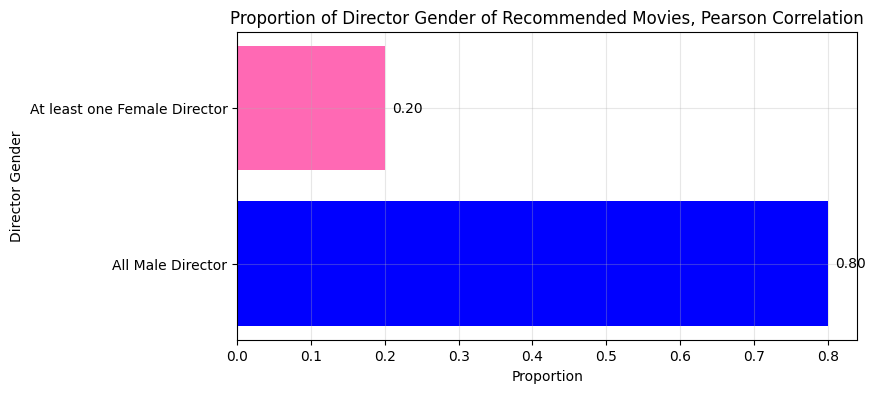

In [57]:
# Calculate mean male director proportion of recommended movies
all_male_director_proportion_pearson = Ratings_and_Movies[Ratings_and_Movies['movie_id'].isin(list(top_recommendations_pearson_reweighed['movie_id']))].drop_duplicates(subset='movie_id')['all_male_director'].mean()

# Calculate female director proportion
female_director_proportion_pearson = 1 - all_male_director_proportion_pearson

# Data for the horizontal bar chart
labels = ['All Male Director', 'At least one Female Director']
proportions = [all_male_director_proportion_pearson, female_director_proportion_pearson]

# Plotting the horizontal bar chart
plt.figure(figsize=(8, 4))
plt.barh(labels, proportions, color=['blue', '#FF69B4'])
plt.title('Proportion of Director Gender of Recommended Movies, Pearson Correlation')
plt.xlabel('Proportion')
plt.ylabel('Director Gender')

# Adding values to the bars
for i, proportion in enumerate(proportions):
    plt.text(proportion + 0.01, i, f'{proportion:.2f}', va='center')

# Customize grid lines
plt.grid(alpha=0.3)

# Show plot
plt.show()

Despite applying the reweighted dataset to the recommender models utilizing Jaccard and Cosine Similarity, and Pearson Correlation, there was no difference in the diversity of movie recommendations. The top movie recommendations continued to exhibit a dominance of male-directed content, indicating that the reweighing technique did not effectively mitigate gender bias in the recommendation process.

It appears that reweighing the dataset did not impact the calculation of the similarity metrics, resulting in the same top 10 movie recommendations before and after bias mitigation in the model.

#### Recommender System Bias Mitigation (Surprise)

Like the other similarity metrics above, SVD relies on user-item interaction data to make recommendations. By using a reweighted dataset, which adjusts the representation of male-directed and female-directed movies, we investigate whether there is a difference in recommended movies before and after mitigation.

##### Calculating disparate impact for Ratings_and_Movies Dataframe

In [58]:
movies_aif360_dataset = StandardDataset(Ratings_and_Movies,
                                 label_name='user_rating',
                                 favorable_classes=favorable_classes,
                                 protected_attribute_names=protected_attributes,
                                 privileged_classes=[[1]])

# Calculate disparate impact before any mitigation
movies_metric_before = BinaryLabelDatasetMetric(movies_aif360_dataset, unprivileged_groups=[{'all_male_director': 0}],
                                         privileged_groups=[{'all_male_director': 1}])
movies_disparate_impact_before = movies_metric_before.disparate_impact()

print("Disparate Impact for Ratings_and_Movies DF Before Mitigation:", movies_disparate_impact_before)
print("Statistical Parity Difference for Ratings_and_Movies DF Before Mitigation:", movies_metric_before.statistical_parity_difference())

Disparate Impact for Ratings_and_Movies DF Before Mitigation: 0.6936728137652075
Statistical Parity Difference for Ratings_and_Movies DF Before Mitigation: -0.06811093669303028


##### Making predictions with SVD using Ratings_and_Movies Dataframe & and calculating bias metrics

In [59]:
# Create a Surprise Reader object
reader = Reader(rating_scale=(1, 5))

# Load data from DataFrame to Surprise Dataset
data = Dataset.load_from_df(Ratings_and_Movies[['user_id', 'movie_id', 'user_rating']], reader)

# Split the data into train and test sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Initialize the SVD algorithm
svd = SVD()

# Train the algorithm on the training set
svd.fit(trainset)

# Get all unique user IDs
all_user_ids = Ratings_and_Movies['user_id'].unique()

# Initialize an empty list to store predictions
all_predictions = []

# Iterate through all user IDs and make predictions for all movies
for user_id_to_predict in all_user_ids:
    all_movie_ids = Ratings_and_Movies['movie_id'].unique()
    predictions = [(user_id_to_predict, movie_id, svd.predict(user_id_to_predict, movie_id).est) for movie_id in all_movie_ids]
    all_predictions.extend(predictions)

# Create a DataFrame from all predictions and round the 'predicted_rating' column
predictions_df = pd.DataFrame(all_predictions, columns=['user_id', 'movie_id', 'predicted_rating'])
predictions_df['predicted_rating'] = predictions_df['predicted_rating'].round()

# Include additional features from Ratings_and_Movies DataFrame
predictions_df = pd.merge(predictions_df,
                                    Ratings_and_Movies[['user_id', 'movie_id', 'all_male_director']],
                                    on=['user_id', 'movie_id'])

# Define protected attributes
protected_attributes = ['all_male_director']

# Define favorable classes (e.g., high ratings)
favorable_classes = [5]

# Create a StandardDataset using predictions dataframe
aif360_dataset = StandardDataset(predictions_df,
                                 label_name='predicted_rating',
                                 favorable_classes=favorable_classes,
                                 protected_attribute_names=protected_attributes,
                                 privileged_classes=[[1]])

# Calculate disparate impact before any mitigation
metric_before = BinaryLabelDatasetMetric(aif360_dataset, unprivileged_groups=[{'all_male_director': 0}],
                                         privileged_groups=[{'all_male_director': 1}])
disparate_impact_before = metric_before.disparate_impact()

print("Disparate Impact for Predictions DF Before Mitigation:", disparate_impact_before)
print("Statistical Parity Difference for Predictions DF Before Mitigation:", metric_before.statistical_parity_difference())

# Make predictions on the test set
predictions = svd.test(testset)

# Calculate and print the RMSE (Root Mean Squared Error) on the test set
rmse_before = accuracy.rmse(predictions)
print("RMSE Before Mitigation:", rmse_before)

# Calculate and print the MAE (Mean Absolute Error) on the test set
mae_before = accuracy.mae(predictions)
print("MAE Before Mitigation:", mae_before)

Disparate Impact for Predictions DF Before Mitigation: 0.39549885925283673
Statistical Parity Difference for Predictions DF Before Mitigation: -0.05260369714072839
RMSE: 0.8811
RMSE Before Mitigation: 0.8810828262131487
MAE:  0.6944
MAE Before Mitigation: 0.6943644527732283


##### Reweighing Ratings_and_Movies dataframe before feeding into the SVD algorithm and re-calculating bias metrics

In [60]:
# Apply Reweighing as a bias mitigation technique
rw = Reweighing(unprivileged_groups=[{'all_male_director': 0}], privileged_groups=[{'all_male_director': 1}])
aif360_dataset_reweighed = rw.fit_transform(movies_aif360_dataset)

# Calculate disparate impact after mitigation
metric_after = BinaryLabelDatasetMetric(aif360_dataset_reweighed, unprivileged_groups=[{'all_male_director': 0}],
                                        privileged_groups=[{'all_male_director': 1}])
disparate_impact_after = metric_after.disparate_impact()

print("Disparate Impact for Ratings_and_Movies DF After Mitigation:", disparate_impact_after)
print("Statistical Parity Difference for Ratings_and_Movies DF After Mitigation:", metric_after.statistical_parity_difference())

# Convert StandardDataset to DataFrame
aif360_df_reweighed = aif360_dataset_reweighed.convert_to_dataframe()[0]

Disparate Impact for Ratings_and_Movies DF After Mitigation: 0.9999999999999998
Statistical Parity Difference for Ratings_and_Movies DF After Mitigation: -5.551115123125783e-17


##### New rating predictions with reweighed dataset

In [61]:
# Split the DataFrame into train and test sets
train_df, test_df = sklearn_train_test_split(aif360_df_reweighed[['movie_id', 'user_id', 'user_rating_copy']], test_size=0.2, random_state=42)

# Initialize the SVD algorithm for the new DataFrame with the reweighed dataset
svd_reweighed = SVD()

# Load data from DataFrame to Surprise Dataset for training
trainset_reweighed = Dataset.load_from_df(train_df[['user_id', 'movie_id', 'user_rating_copy']], reader).build_full_trainset()

# Train the algorithm on the training set for the new DataFrame with the reweighed dataset
svd_reweighed.fit(trainset_reweighed)

# Load data from DataFrame to Surprise Dataset for testing
testset_reweighed = Dataset.load_from_df(test_df[['user_id', 'movie_id', 'user_rating_copy']], reader)

# Make predictions on the test set for the new DataFrame with the reweighed dataset
predictions_after_mitigation_reweighed = svd_reweighed.test(testset_reweighed.build_full_trainset().build_testset())

new_all_user_ids = Ratings_and_Movies['user_id'].unique()

new_all_predictions = []

for new_user_id_to_predict in new_all_user_ids:
    new_all_movie_ids = Ratings_and_Movies['movie_id'].unique()
    new_predictions = [(new_user_id_to_predict, movie_id, svd_reweighed.predict(new_user_id_to_predict, movie_id).est) for movie_id in new_all_movie_ids]
    new_all_predictions.extend(new_predictions)


new_predictions_df = pd.DataFrame(new_all_predictions, columns = ['user_id', 'movie_id', 'predicted_rating'])
new_predictions_df['predicted_rating'] = new_predictions_df['predicted_rating'].round()
new_predictions_df = pd.merge(new_predictions_df,
                              Ratings_and_Movies[['user_id', 'movie_id', 'all_male_director']],
                              on = ['user_id', 'movie_id'])

##### Calculating bias metrics for new predictions dataframe since it used the reweighed Ratings_and_Movies dataframe, and model utility

In [62]:
# Create a StandardDataset using new predictions dataframe
new_aif360_dataset = StandardDataset(new_predictions_df,
                                 label_name='predicted_rating',
                                 favorable_classes=favorable_classes,
                                 protected_attribute_names=protected_attributes,
                                 privileged_classes=[[1]])

# Calculate disparate impact before any mitigation
new_metric_before = BinaryLabelDatasetMetric(new_aif360_dataset, unprivileged_groups=[{'all_male_director': 0}],
                                         privileged_groups=[{'all_male_director': 1}])
new_disparate_impact_before = new_metric_before.disparate_impact()

print("Disparate Impact for NEW Predictions DF After Mitigation:", new_disparate_impact_before)
print("Statistical Parity Difference for NEW Predictions DF After Mitigation:", new_metric_before.statistical_parity_difference())


# Calculate and print the RMSE (Root Mean Squared Error) on the test set after mitigation with reweighing
rmse_after_mitigation_reweighed = accuracy.rmse(predictions_after_mitigation_reweighed)
print("RMSE After Mitigation (Reweighing):", rmse_after_mitigation_reweighed)

# Calculate and print the MAE (Mean Absolute Error) on the test set after mitigation with reweighing
mae_after_mitigation_reweighed = accuracy.mae(predictions_after_mitigation_reweighed)
print("MAE After Mitigation (Reweighing):", mae_after_mitigation_reweighed)

Disparate Impact for NEW Predictions DF After Mitigation: 0.3865025639650198
Statistical Parity Difference for NEW Predictions DF After Mitigation: -0.05326463545321206
RMSE: 0.8766
RMSE After Mitigation (Reweighing): 0.8766169508170991
MAE:  0.6895
MAE After Mitigation (Reweighing): 0.6895268784191407


The reweighing technique was failed at mitigating bias in the SVD recommendation system. The disparate impact stayed largely the same before and after reweighing.

Additionally, reweighing did not substantially alter the accuracy of the recommender system's predictions, as evidenced by consistent RMSE and MAE values before and after mitigation.

### [5.](#Table-of-Contents) Results Summary 

**To Do**

### [6.](#Table-of-Contents) Conclusion & Discussion 

**Conclusion is To-Do**

Although bias mitigation using reweighing proved to be successful in the various recommender systems above, the basis of reweighing lies in addressing dataset imbalances. Because of the underrepresentation of female film directors in the dataset, reweighing adjusts the distribution of instances across different groups. This may lead to a reduction in the sample size of the majority group to achieve parity, which loses data and can limit the model's ability to capture the full complexity of the dataset.

Additionally, simply examining the director's gender in movie recommender systems is not enough to consider for a model that can impact so many different stakeholders. It is essential to consider how gender can intersect with other demographic factors. For example, a movie recommender system can exhibit different biases based on both the gender and race of the director. The recommender may perform differently for a movie by a Black male director versus a movie by a white male director, despite both movies featuring a male director. As such, intersectionality with gender must be examined as different demographic groups may result in different bias mitigation strategies being the most effective.

Lastly, while the bias mitigation techniques in this project were able to achieve a "fair" model in terms of statistical fairness metrics, these techniques do not fully address the underlying systemic biases present in society. The underrepresentation of female-directed movies in the dataset stems from gender biases present in the film industry, where women face more discrimination and receive less support. Technosolutionism refers to the reliance on technological solutions to address complex social issues, ignoring broader societal, ethical, and political implications. Bias mitigation in recommender systems is an important step in achieving fairness and equity in movie recommendation systems, but bias mitigation alone cannot effectively address biases without the work of fields such as sociology, cultural, and media studies to work towards changing the dynamics that influence film production, distribution, and consumption.